## 모델 학습을 위한 데이터 전처리

구글 드라이브 연결 및 데이터 로딩 시작...
Mounted at /content/drive
학습 데이터 로딩 중...
검증 데이터 로딩 중...
증강 ALL 검증 데이터 로딩 중...
증강 rotate 검증 데이터 로딩 중...
증강 scale 검증 데이터 로딩 중...
증강 shear 검증 데이터 로딩 중...
증강 shift 검증 데이터 로딩 중...

원본 학습 데이터 Shape: (60000, 28, 28, 3)
색상 분류용 데이터 (Color): (60000, 2352)

배경 제거 중 (코너 기반 Rule-based)...
배경 제거 후 학습 데이터 Shape: (60000, 28, 28, 3)
배경 제거 후 검증 데이터 Shape: (10000, 28, 28, 3)


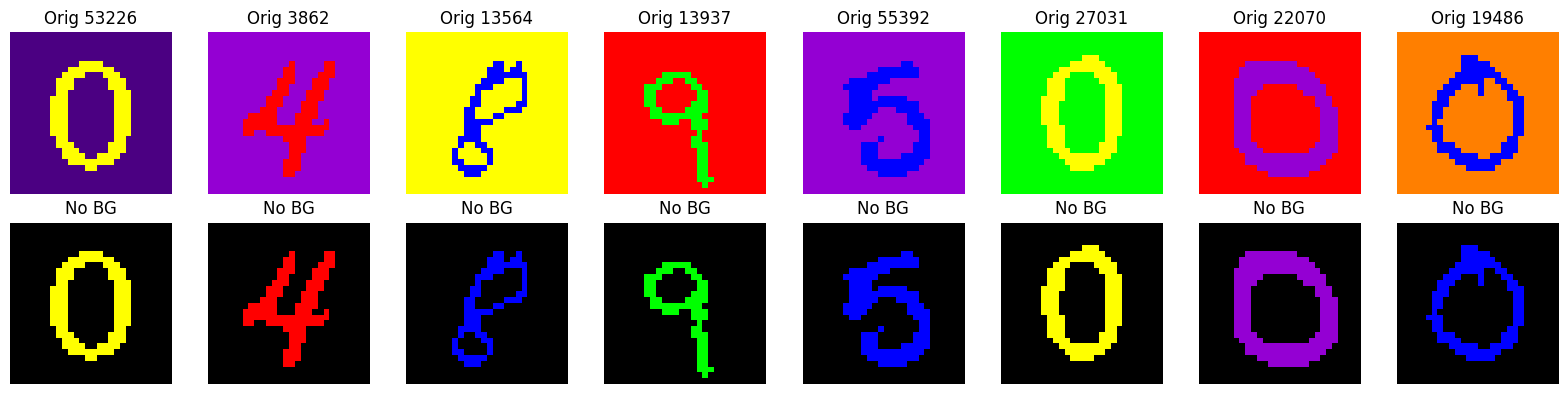


색상 분류용 데이터 (원본 Color): (60000, 2352)
색상 분류용 데이터 (배경제거 Color): (60000, 2352)


In [1]:
import numpy as np
import os
import time
# Colab에서는 cupy, cuml이 기본 설치되어 있지 않으므로 주석 처리하거나 대체합니다.
# import cupy as cp
from google.colab import drive
from tqdm.notebook import tqdm
from skimage.feature import hog
import matplotlib.pyplot as plt

# 3개의 핵심 모델 임포트
# cuml(GPU) 대신 sklearn(CPU) RandomForest 사용
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

# 평가 지표 임포트 (sklearn 사용)
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report as sk_classification_report
from sklearn.metrics import roc_auc_score as sk_roc_auc_score
import warnings

warnings.filterwarnings("ignore", message="X does not have valid feature names")
warnings.filterwarnings("ignore", message="Using CPU for workflow synchronization")

# --- 1. 설정 및 데이터 로딩 ---
print("구글 드라이브 연결 및 데이터 로딩 시작...")

# 구글 드라이브 마운트
drive.mount('/content/drive')

# 경로 설정 (사용자 환경에 맞게 수정 필요)
BASE_DIR = '/content/drive/MyDrive/ML/Data'

SAVE_PATH_TRAIN = os.path.join(BASE_DIR, 'colored_mnist_train.npz')
SAVE_PATH_VAL = os.path.join(BASE_DIR, 'colored_mnist_val.npz')
# 추가 검증 데이터셋 경로
SAVE_PATH_VAL_ALL = os.path.join(BASE_DIR, 'colored_mnist_valid_all.npz')
SAVE_PATH_VAL_ROTATE = os.path.join(BASE_DIR, 'colored_mnist_valid_rotate.npz')
SAVE_PATH_VAL_SCALE = os.path.join(BASE_DIR, 'colored_mnist_valid_scale.npz')
SAVE_PATH_VAL_SHEAR = os.path.join(BASE_DIR, 'colored_mnist_valid_shear.npz')
SAVE_PATH_VAL_SHIFT = os.path.join(BASE_DIR, 'colored_mnist_valid_shift.npz')

NUM_CLASSES_DIGIT = 10  # 숫자 (0~9)
NUM_CLASSES_COLOR = 7   # 색상 (무지개 7색)

# 학습 데이터 로드
print("학습 데이터 로딩 중...")
train_data = np.load(SAVE_PATH_TRAIN)
X_train_color = train_data['images'].astype(np.float32)
y_train_digit = train_data['labels_digit'].astype(np.float32)
y_train_fg = train_data['labels_fg'].astype(np.float32)
y_train_bg = train_data['labels_bg'].astype(np.float32)

# 테스트 데이터 로드
print("검증 데이터 로딩 중...")
val_data = np.load(SAVE_PATH_VAL)
X_val_color = val_data['images'].astype(np.float32)
y_val_digit = val_data['labels_digit'].astype(np.float32)
y_val_fg = val_data['labels_fg'].astype(np.float32)
y_val_bg = val_data['labels_bg'].astype(np.float32)

print("증강 ALL 검증 데이터 로딩 중...")
val_data = np.load(SAVE_PATH_VAL_ALL)
X_val_all_color = val_data['images'].astype(np.float32)
y_val_all_digit = val_data['labels_digit'].astype(np.float32)
y_val_all_fg = val_data['labels_fg'].astype(np.float32)
y_val_all_bg = val_data['labels_bg'].astype(np.float32)

print("증강 rotate 검증 데이터 로딩 중...")
val_data = np.load(SAVE_PATH_VAL_ROTATE)
X_val_rotate_color = val_data['images'].astype(np.float32)
y_val_rotate_digit = val_data['labels_digit'].astype(np.float32)
y_val_rotate_fg = val_data['labels_fg'].astype(np.float32)
y_val_rotate_bg = val_data['labels_bg'].astype(np.float32)

print("증강 scale 검증 데이터 로딩 중...")
val_data = np.load(SAVE_PATH_VAL_SCALE)
X_val_scale_color = val_data['images'].astype(np.float32)
y_val_scale_digit = val_data['labels_digit'].astype(np.float32)
y_val_scale_fg = val_data['labels_fg'].astype(np.float32)
y_val_scale_bg = val_data['labels_bg'].astype(np.float32)

print("증강 shear 검증 데이터 로딩 중...")
val_data = np.load(SAVE_PATH_VAL_SHEAR)
X_val_shear_color = val_data['images'].astype(np.float32)
y_val_shear_digit = val_data['labels_digit'].astype(np.float32)
y_val_shear_fg = val_data['labels_fg'].astype(np.float32)
y_val_shear_bg = val_data['labels_bg'].astype(np.float32)

print("증강 shift 검증 데이터 로딩 중...")
val_data = np.load(SAVE_PATH_VAL_SHIFT)
X_val_shift_color = val_data['images'].astype(np.float32)
y_val_shift_digit = val_data['labels_digit'].astype(np.float32)
y_val_shift_fg = val_data['labels_fg'].astype(np.float32)
y_val_shift_bg = val_data['labels_bg'].astype(np.float32)

print(f"\n원본 학습 데이터 Shape: {X_train_color.shape}")


# --- 2. 데이터 전처리 ---
# 2-1. 색상 분류용 (Color 3D -> 1D Flatten)
X_train_flat_color = X_train_color.reshape(X_train_color.shape[0], -1)
X_val_flat_color = X_val_color.reshape(X_val_color.shape[0], -1)
X_val_all_flat_color = X_val_all_color.reshape(X_val_color.shape[0], -1)
X_val_rotate_flat_color = X_val_rotate_color.reshape(X_val_color.shape[0], -1)
X_val_scale_flat_color = X_val_scale_color.reshape(X_val_color.shape[0], -1)
X_val_shear_flat_color = X_val_shear_color.reshape(X_val_color.shape[0], -1)
X_val_shift_flat_color = X_val_shift_color.reshape(X_val_color.shape[0], -1)

print(f"색상 분류용 데이터 (Color): {X_train_flat_color.shape}")
def remove_background_corner_rule(images, patch_size=2, threshold=30, bg_value=0):
    """
    images: (N, H, W, 3)  - RGB 이미지 (0~1 또는 0~255)
    patch_size: 코너에서 가져올 패치 크기 (2면 2x2)
    threshold: 배경으로 볼 색 거리 허용치 (클수록 더 많이 배경으로 봄)
    bg_value: 배경으로 덮어쓸 값 (0이면 검정)
    """
    N, H, W, C = images.shape
    out = np.zeros_like(images)

    for i in range(N):
        img = images[i]

        # 원본이 0~1 float 형식일 수도 있고, 0~255일 수도 있으니 uint8 기준으로 처리
        if img.max() <= 1.0:
            img_uint = (img * 255).astype(np.uint8)
            is_float = True
        else:
            img_uint = img.astype(np.uint8)
            is_float = False

        # 코너 패치들 가져오기 (4개 코너)
        tl = img_uint[0:patch_size, 0:patch_size, :]          # top-left
        tr = img_uint[0:patch_size, W-patch_size:W, :]        # top-right
        bl = img_uint[H-patch_size:H, 0:patch_size, :]        # bottom-left
        br = img_uint[H-patch_size:H, W-patch_size:W, :]      # bottom-right

        corner_pixels = np.concatenate([
            tl.reshape(-1, 3),
            tr.reshape(-1, 3),
            bl.reshape(-1, 3),
            br.reshape(-1, 3)
        ], axis=0)

        # 코너 평균 색 = 배경색으로 가정
        bg_color = corner_pixels.mean(axis=0)  # (3,)

        # 각 픽셀과 배경색 거리 계산
        diff = np.linalg.norm(img_uint - bg_color, axis=2)  # (H, W)

        # threshold 이하인 픽셀은 배경으로 처리
        mask_bg = diff < threshold

        out_uint = img_uint.copy()
        out_uint[mask_bg] = bg_value  # 배경 제거(검정으로)

        # 다시 원래 스케일로 복원
        if is_float:
            out[i] = out_uint.astype(np.float32) / 255.0
        else:
            out[i] = out_uint

    return out


print("\n배경 제거 중 (코너 기반 Rule-based)...")
X_train_nobg = remove_background_corner_rule(X_train_color, patch_size=2, threshold=30, bg_value=0)
X_val_nobg   = remove_background_corner_rule(X_val_color,   patch_size=2, threshold=30, bg_value=0)
X_val_all_nobg   = remove_background_corner_rule(X_val_all_color,   patch_size=2, threshold=30, bg_value=0)
X_val_rotate_nobg   = remove_background_corner_rule(X_val_rotate_color,   patch_size=2, threshold=30, bg_value=0)
X_val_scale_nobg   = remove_background_corner_rule(X_val_scale_color,   patch_size=2, threshold=30, bg_value=0)
X_val_shear_nobg   = remove_background_corner_rule(X_val_shear_color,   patch_size=2, threshold=30, bg_value=0)
X_val_shift_nobg   = remove_background_corner_rule(X_val_shift_color,   patch_size=2, threshold=30, bg_value=0)
print("배경 제거 후 학습 데이터 Shape:", X_train_nobg.shape)
print("배경 제거 후 검증 데이터 Shape:", X_val_nobg.shape)


# ===============================
# 3. 배경제거 결과 시각화 (샘플 8개)
# ===============================
num_samples = 8
idx = np.random.choice(X_train_color.shape[0], num_samples, replace=False)

plt.figure(figsize=(16, 4))

# 1행: 원본 / 2행: 배경제거 결과
for col, i in enumerate(idx):
    # 원본
    ax1 = plt.subplot(2, num_samples, col + 1)
    ax1.imshow(X_train_color[i])
    ax1.axis('off')
    ax1.set_title(f"Orig {i}")

    # 배경제거
    ax2 = plt.subplot(2, num_samples, num_samples + col + 1)
    ax2.imshow(X_train_nobg[i])
    ax2.axis('off')
    ax2.set_title("No BG")

plt.tight_layout()
plt.show()


# ===============================
# 4. 색상 분류용 Flatten (원본 / 배경제거 둘 다 만들어두기)
# ===============================

# (1) 원본 Color -> Flatten  (BG Color 등 원본이 필요한 경우)
X_train_flat_color = X_train_color.reshape(X_train_color.shape[0], -1)
X_val_flat_color   = X_val_color.reshape(X_val_color.shape[0], -1)
print(f"\n색상 분류용 데이터 (원본 Color): {X_train_flat_color.shape}")

# (2) 배경 제거 버전 -> Flatten (Digit / FG Color 등에서 사용)
X_train_flat_nobg = X_train_nobg.reshape(X_train_nobg.shape[0], -1)
X_val_flat_nobg   = X_val_nobg.reshape(X_val_nobg.shape[0], -1)
X_val_all_flat_nobg = X_val_all_nobg.reshape(X_val_color.shape[0], -1)
X_val_rotate_flat_nobg = X_val_rotate_nobg.reshape(X_val_color.shape[0], -1)
X_val_scale_flat_nobg = X_val_scale_nobg.reshape(X_val_color.shape[0], -1)
X_val_shear_flat_nobg = X_val_shear_nobg.reshape(X_val_color.shape[0], -1)
X_val_shift_flat_nobg = X_val_shift_nobg.reshape(X_val_color.shape[0], -1)
print(f"색상 분류용 데이터 (배경제거 Color): {X_train_flat_nobg.shape}")

## 그레이 스케일 없이 모델 학습

In [3]:
# 필요한 라이브러리 임포트 (앞 셀에서 안 했을 경우를 대비해 안전하게 추가)
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from tqdm.notebook import tqdm

print("\n--- 3종 모델 학습 시작 (총 9개) ---")

# 학습할 모델과 데이터를 '작업 목록'으로 정의
training_jobs = [
    # 1. RandomForest (CPU 사용, n_jobs=-1로 병렬 처리)
    # 기존 cuRF 대신 sklearn의 RandomForestClassifier를 사용합니다.
    ("RandomForest - Digit", RandomForestClassifier(n_estimators=100, random_state=42, max_depth=16, n_jobs=-1), X_train_flat_color, y_train_digit),
    ("RandomForest - FG Color", RandomForestClassifier(n_estimators=100, random_state=42, max_depth=16, n_jobs=-1), X_train_flat_color, y_train_fg),
    ("RandomForest - BG Color", RandomForestClassifier(n_estimators=100, random_state=42, max_depth=16, n_jobs=-1), X_train_flat_color, y_train_bg),

    # 2. XGBoost (GPU 사용)
    # Colab T4 GPU를 사용하기 위해 ', tree_method='hist' 설정
    ("XGBoost - Digit", xgb.XGBClassifier(n_estimators=100, random_state=42, objective='multi:softmax', eval_metric='mlogloss', num_class=NUM_CLASSES_DIGIT, tree_method='hist', n_jobs = -1), X_train_flat_color, y_train_digit),
    ("XGBoost - FG Color", xgb.XGBClassifier(n_estimators=100, random_state=42, objective='multi:softmax', eval_metric='mlogloss', num_class=NUM_CLASSES_COLOR, tree_method='hist', n_jobs = -1), X_train_flat_color, y_train_fg),
    ("XGBoost - BG Color", xgb.XGBClassifier(n_estimators=100, random_state=42, objective='multi:softmax', eval_metric='mlogloss', num_class=NUM_CLASSES_COLOR, tree_method='hist', n_jobs = -1), X_train_flat_color, y_train_bg),

    # 3. LightGBM (CPU 사용)
    # Colab 기본 설치 버전은 CPU만 지원하므로 n_jobs=-1로 속도 최적화
    ("LightGBM - Digit", lgb.LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1, objective='multiclass', num_class=NUM_CLASSES_DIGIT, verbose=-1), X_train_flat_color, y_train_digit),
    ("LightGBM - FG Color", lgb.LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1, objective='multiclass', num_class=NUM_CLASSES_COLOR, verbose=-1), X_train_flat_color, y_train_fg),
    ("LightGBM - BG Color", lgb.LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1, objective='multiclass', num_class=NUM_CLASSES_COLOR, verbose=-1), X_train_flat_color, y_train_bg),
]

# 학습된 모델들을 저장할 딕셔너리
trained_models = {}

# TQDM으로 작업 목록을 감싸서 진행도 표시
for name, model, X_train_data, y_train_data in tqdm(training_jobs, desc="Overall Training Progress"):
    print(f"학습 시작: {name}")
    model.fit(X_train_data, y_train_data)
    trained_models[name] = model

print("--- 모든 모델 학습 완료 ---")


--- 3종 모델 학습 시작 (총 9개) ---


Overall Training Progress:   0%|          | 0/9 [00:00<?, ?it/s]

학습 시작: RandomForest - Digit
학습 시작: RandomForest - FG Color
학습 시작: RandomForest - BG Color
학습 시작: XGBoost - Digit
학습 시작: XGBoost - FG Color
학습 시작: XGBoost - BG Color
학습 시작: LightGBM - Digit
학습 시작: LightGBM - FG Color
학습 시작: LightGBM - BG Color
--- 모든 모델 학습 완료 ---


## 그레이스케일 미적용 모델 성능 평가

In [9]:
def evaluate_model_org(model_name, model_obj):
    print(f"\n===== {model_name} =====")

    # 1. 검증 데이터 선택
    if "Digit" in model_name:
        X_val, y_val = X_val_flat_color, y_val_digit
    elif "FG Color" in model_name:
        X_val, y_val = X_val_flat_color, y_val_fg
    else: # BG Color
        X_val, y_val = X_val_flat_color, y_val_bg

    # 2. 예측
    # 이전 코드의 cuRF(GPU) 분기 처리를 제거하고 표준 sklearn 방식으로 통일합니다.
    # 변경된 RandomForest와 GPU 설정된 XGBoost 모두 numpy 배열을 입력받을 수 있습니다.
    try:
        y_pred = model_obj.predict(X_val)
        y_proba = model_obj.predict_proba(X_val)
    except Exception as e:
        print(f"예측 중 에러 발생 ({model_name}): {e}")
        return

    # 3. 결과 출력 (sklearn 함수 사용)
    # y_val과 y_pred의 형식이 맞는지 확인 (가끔 float/int 불일치 경고가 뜰 수 있음)
    y_val = y_val.astype(int)
    y_pred = y_pred.astype(int)

    print(sk_classification_report(y_val, y_pred, digits=4))

    try:
        auc = sk_roc_auc_score(y_val, y_proba, multi_class='ovr', average='weighted')
        print(f"** Weighted-Average AUC: {auc:.4f} **")
    except Exception as e:
        print(f"AUC 계산 중 오류 (클래스 불균형 등 원인일 수 있음): {e}")

print("\n--- 최종 성능 평가 (Validation Set) ---")

# 학습된 모델들을 순회하며 평가
# (만약 trained_models가 비어있다면 앞선 학습 셀을 먼저 실행해야 합니다)
if 'trained_models' in locals() and trained_models:
    for name, model in trained_models.items():
        evaluate_model_org(name, model)
else:
    print("⚠️ 학습된 모델이 없습니다. 앞선 '모델 학습' 셀을 먼저 실행해주세요.")


--- 최종 성능 평가 (Validation Set) ---

===== RandomForest - Digit =====
              precision    recall  f1-score   support

           0     0.9532    0.9846    0.9686       972
           1     0.9547    0.9902    0.9721      1021
           2     0.9488    0.9073    0.9276       939
           3     0.9348    0.9118    0.9232       975
           4     0.9328    0.9576    0.9451      1015
           5     0.9263    0.9281    0.9272      1029
           6     0.9549    0.9641    0.9595      1032
           7     0.9529    0.9490    0.9509       980
           8     0.9442    0.9110    0.9273      1022
           9     0.9298    0.9261    0.9279      1015

    accuracy                         0.9432     10000
   macro avg     0.9432    0.9430    0.9429     10000
weighted avg     0.9431    0.9432    0.9430     10000

** Weighted-Average AUC: 0.9944 **

===== RandomForest - FG Color =====
              precision    recall  f1-score   support

           0     1.0000    0.9993    0.9996  

--- Confusion Matrix 생성 중 ---


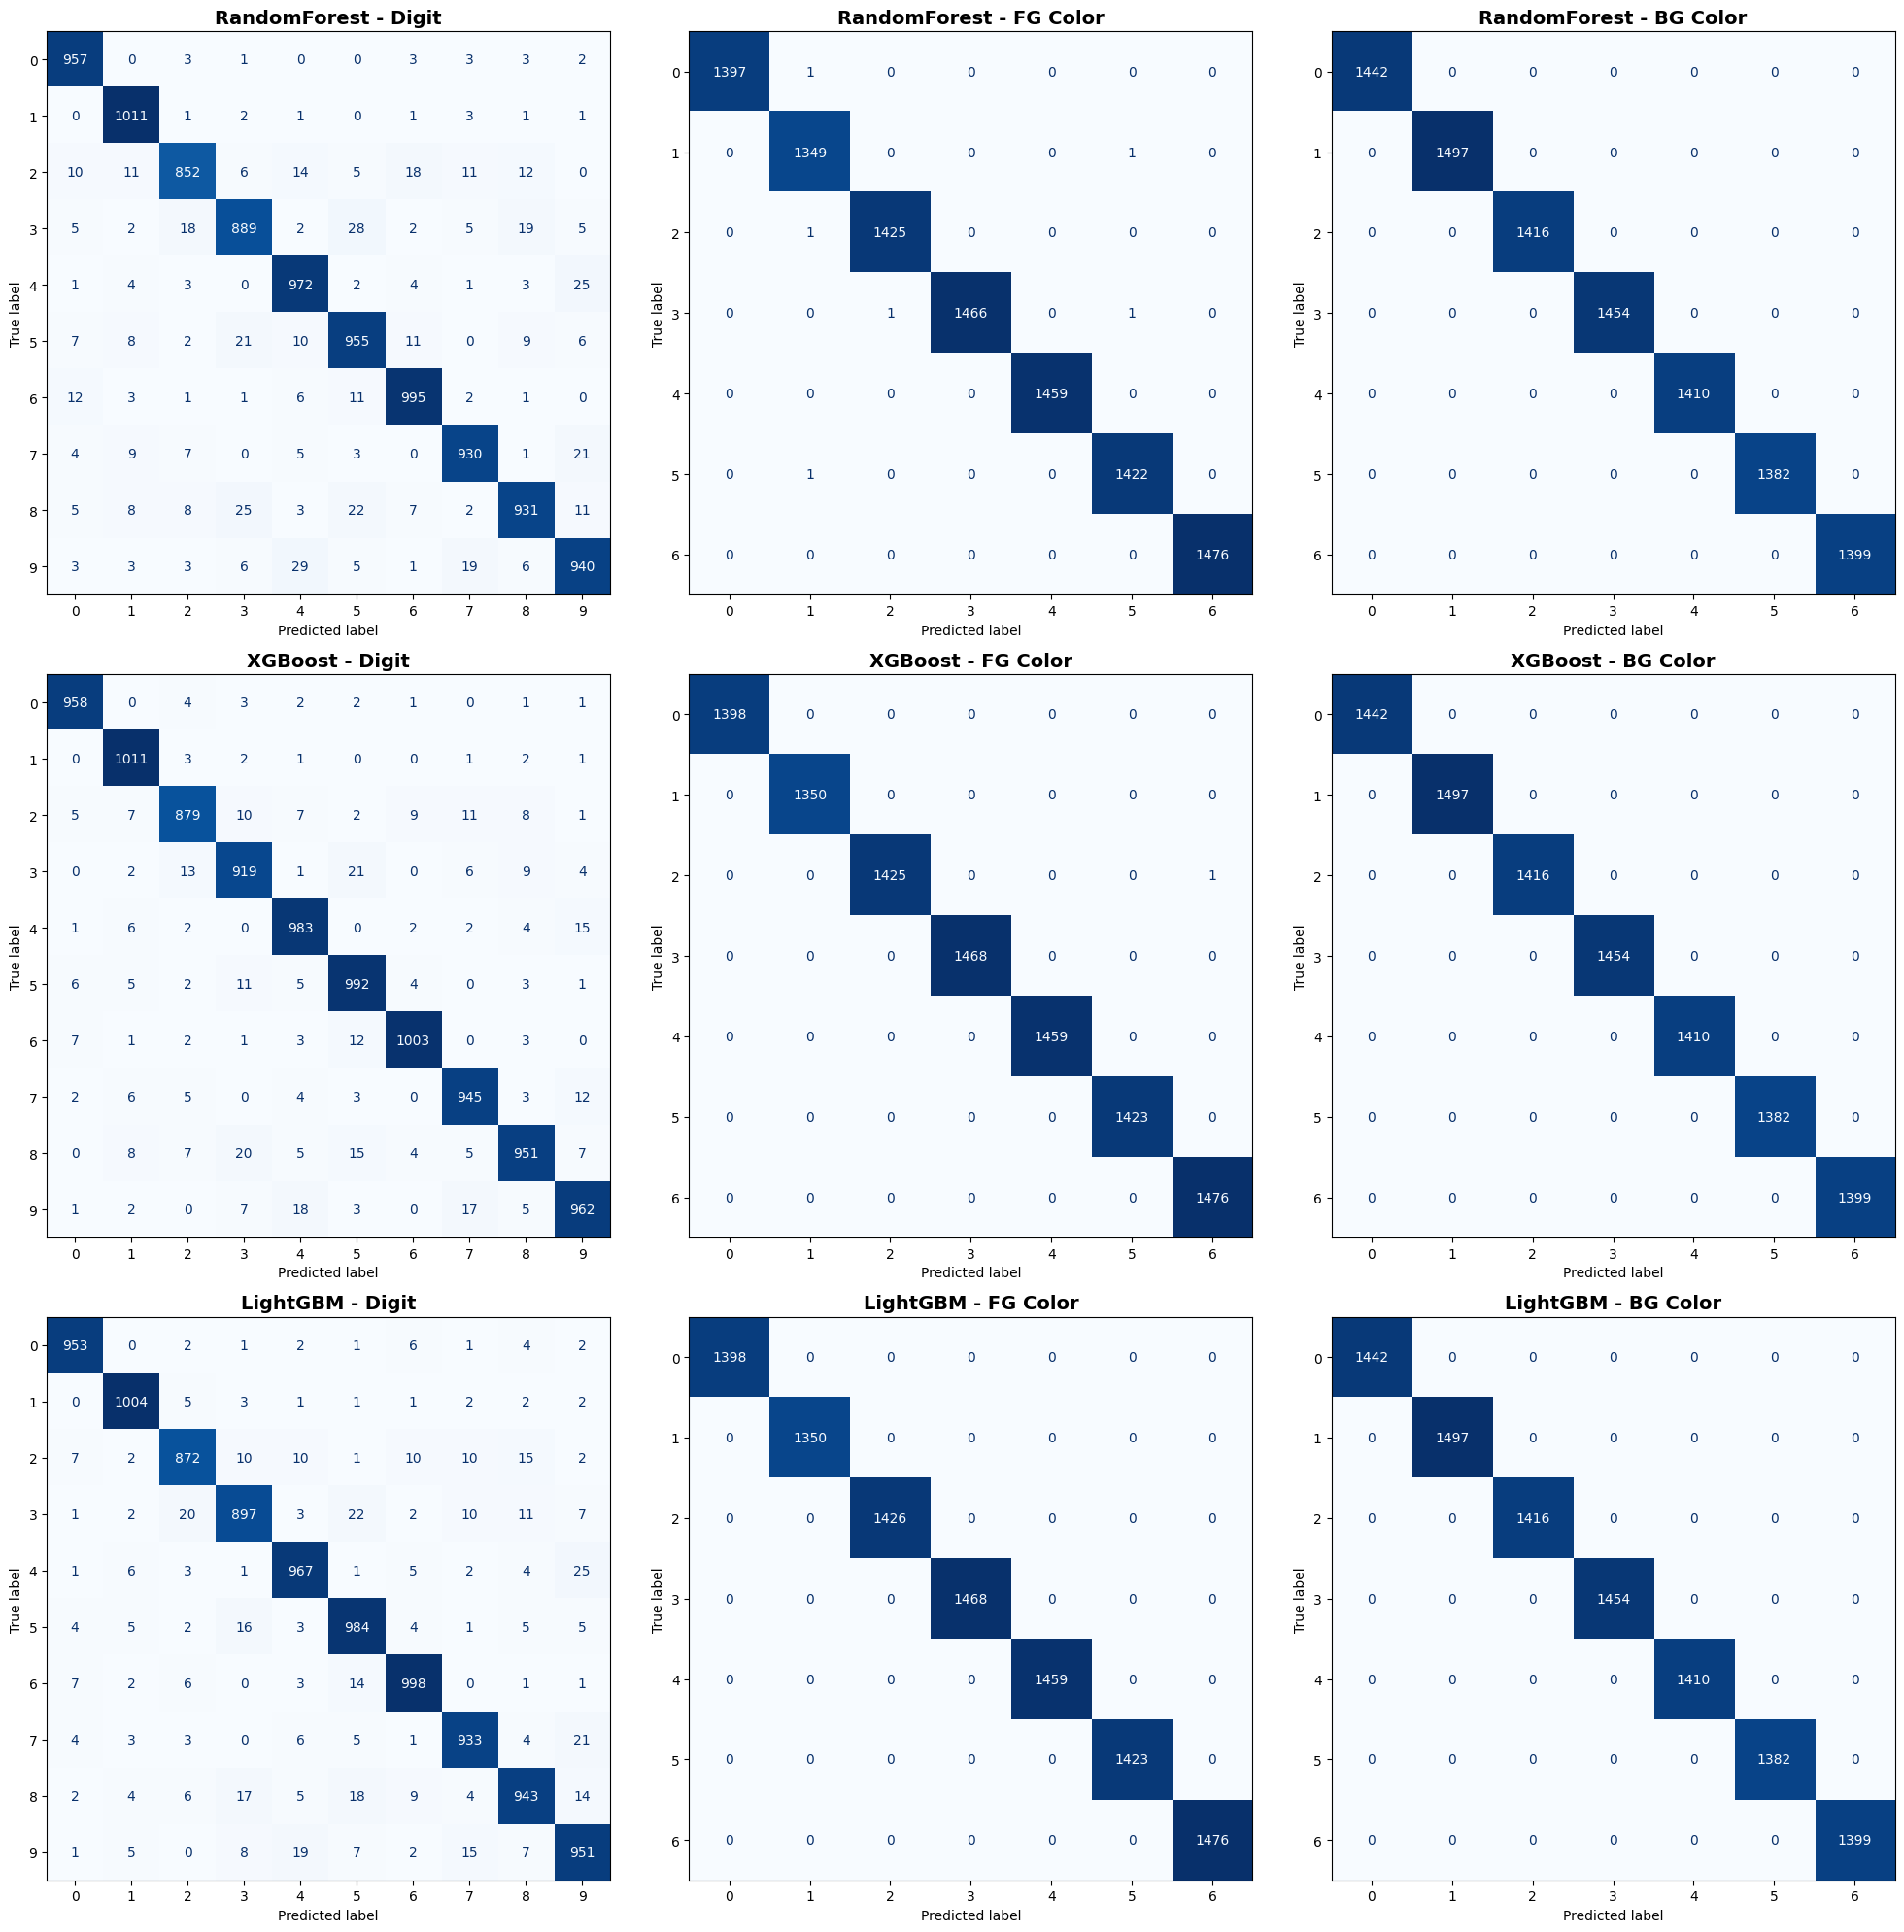

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# 1. 그래프 틀 잡기 (3개 모델 x 3개 태스크 = 9개 서브플롯)
# 4개 모델이 아니라 3개 모델(RF, XGB, LGBM)이므로 3x3 그리드가 딱 맞습니다.
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
axes = axes.flatten() # 1차원으로 펼치기

print("--- Confusion Matrix 생성 중 ---")

# 2. 저장된 모델 하나씩 꺼내서 평가하기
if 'trained_models' not in locals() or not trained_models:
    print("⚠️ 학습된 모델(trained_models)이 없습니다. 앞선 '모델 학습' 셀을 먼저 실행해주세요!")
else:
    for i, (name, model) in enumerate(trained_models.items()):

        # 인덱스 범위 초과 방지 (혹시 모델이 9개보다 많을 경우)
        if i >= len(axes):
            print(f"⚠️ 경고: 그래프 공간 부족으로 '{name}' 모델은 건너뜁니다.")
            break

        # 현재 모델 이름에 따라 적절한 테스트 데이터 선택
        if "Digit" in name:
            X_val = X_val_flat_color
            y_val = y_val_digit
        elif "FG Color" in name: # 전경색
            X_val = X_val_flat_color
            y_val = y_val_fg
        elif "BG Color" in name: # 배경색
            X_val = X_val_flat_color
            y_val = y_val_bg
        else:
            print(f"Error: {name}에 맞는 데이터를 찾지 못했습니다.")
            continue

        # 예측 수행
        # XGBoost(GPU)도 numpy 배열 입력을 받아 numpy 배열을 반환하므로 별도 처리 불필요
        y_pred = model.predict(X_val)

        # [중요] Confusion Matrix는 정수형 라벨을 필요로 합니다.
        y_val_int = y_val.astype(int)
        y_pred_int = y_pred.astype(int)

        # Confusion Matrix 계산
        cm = confusion_matrix(y_val_int, y_pred_int)

        # 시각화 (Plot)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)

        # 그래프 그리기
        disp.plot(ax=axes[i], cmap='Blues', values_format='d', colorbar=False)

        # 제목 설정
        axes[i].set_title(f"{name}", fontsize=14, fontweight='bold')

        # 축 라벨 제거 (깔끔하게 보기 위해 선택사항)
        # axes[i].set_xlabel('')
        # axes[i].set_ylabel('')

    # 레이아웃 정리
    plt.tight_layout()
    plt.show()

In [11]:


import matplotlib.pyplot as plt
import numpy as np
from umap import UMAP
from sklearn.manifold import TSNE

# --- 1. 공통 임베딩 생성 ---
# Colab T4 환경에서는 cuML 설치가 까다로우므로 CPU 버전(umap-learn, sklearn)을 사용합니다.
if 'X_tsne' not in locals():
    print(">>> 차원 축소 좌표 계산 중 (Validation Set - CPU)...")
    print("    (시간이 조금 걸릴 수 있습니다. 잠시만 기다려 주세요.)")

    # 1. UMAP
    print("    - UMAP 계산 중...")
    umap_model = UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
    X_umap = umap_model.fit_transform(X_val_flat_color) # numpy 배열 바로 사용

    # 2. t-SNE
    print("    - t-SNE 계산 중...")
    tsne_model = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42, init='pca', learning_rate='auto')
    X_tsne = tsne_model.fit_transform(X_val_flat_color) # numpy 배열 바로 사용

    print(">>> 좌표 계산 완료\n")

# --- 2. 태스크별 시각화 함수 (정답 제거 버전) ---
def plot_model_predictions_only(task_name):
    print(f"--- Viz: {task_name} (Models Only) ---")

    # 해당 태스크의 모델들 찾기 (trained_models 딕셔너리에서 검색)
    models_for_task = {k: v for k, v in trained_models.items() if task_name in k}

    if not models_for_task:
        print(f"⚠️ '{task_name}' 관련 모델을 찾을 수 없습니다.")
        return

    # 제목과 예측값 수집
    titles = list(models_for_task.keys())
    predictions = []

    for name, model in models_for_task.items():
        # 모든 모델(RF, XGB, LGBM)이 이제 numpy 입력을 받습니다.
        # .get()이나 cp.asarray() 없이 바로 예측합니다.
        pred = model.predict(X_val_flat_color)
        predictions.append(pred)

    # 그래프 그리기 (2행 3열: 정답 제외, 모델 3개 기준)
    # 모델 개수에 따라 열(column) 개수 자동 조정
    n_cols = len(models_for_task)
    if n_cols == 0: return

    fig, axes = plt.subplots(2, n_cols, figsize=(6 * n_cols, 10), constrained_layout=True)

    # 만약 모델이 1개뿐이라면 axes가 1차원이 되므로 2차원으로 맞춰줌
    if n_cols == 1:
        axes = axes.reshape(2, 1)

    # (Row 1) t-SNE
    for i, (title, y_data) in enumerate(zip(titles, predictions)):
        scatter = axes[0, i].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_data, cmap='tab10', s=1, alpha=0.7)
        axes[0, i].set_title(f"t-SNE: {title}", fontsize=12, fontweight='bold')
        axes[0, i].axis('off')

    # (Row 2) UMAP
    for i, (title, y_data) in enumerate(zip(titles, predictions)):
        scatter = axes[1, i].scatter(X_umap[:, 0], X_umap[:, 1], c=y_data, cmap='tab10', s=1, alpha=0.7)
        axes[1, i].set_title(f"UMAP: {title}", fontsize=12, fontweight='bold')
        axes[1, i].axis('off')

    # 공통 컬러바 (오른쪽에 하나만 표시)
    # cbar = fig.colorbar(scatter, ax=axes[:, :], location='right', shrink=0.6)
    # cbar.set_label(f'{task_name} Predicted Class', fontsize=14)

    plt.suptitle(f"Model Predictions Comparison: {task_name}", fontsize=20)
    plt.show()

# --- 3. 전체 실행 ---

# (1) 숫자 분류 (Digit)
plot_model_predictions_only("Digit")

# (2) 전경색 분류 (FG Color)
plot_model_predictions_only("FG Color")

# (3) 배경색 분류 (BG Color)
plot_model_predictions_only("BG Color")

Output hidden; open in https://colab.research.google.com to view.

## 그레이 스케일 적용 모델 학습

In [2]:
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
import time
from tqdm.notebook import tqdm

# 2-2. 숫자 분류용 (Color 3D -> Grayscale 2D -> 1D Flatten)
# RGB(3채널) -> Grayscale(1채널) 변환 공식 적용
print("Grayscale 변환 및 Flatten 중...")
X_train_gray = np.dot(X_train_color[...,:3], [0.299, 0.587, 0.114])
X_val_gray = np.dot(X_val_color[...,:3], [0.299, 0.587, 0.114])
def rgb_to_gray(images):
    """
    images: (N, H, W, 3), 0~1 또는 0~255
    return: (N, H, W) float32 (0~1 스케일)
    """
    if images.max() > 1.0:
        imgs = images.astype(np.float32) / 255.0
    else:
        imgs = images.astype(np.float32)

    #gray = imgs.mean(axis=3)  # (N, H, W), R/G/B 평균 이게 그레이스케일 파라미터 조정
    gray = np.max(imgs, axis=3)
    return gray

print("\n배경 제거된 이미지 Grayscale 변환 중...")
X_train_gray = rgb_to_gray(X_train_color)
X_val_gray = rgb_to_gray(X_val_color)
X_val_all_gray   = rgb_to_gray(X_val_all_color)
X_val_rotate_gray   = rgb_to_gray(X_val_rotate_color)
X_val_scale_gray   = rgb_to_gray(X_val_scale_color)
X_val_shear_gray   = rgb_to_gray(X_val_shear_color)
X_val_shift_gray   = rgb_to_gray(X_val_shift_color)
X_train_nobg_gray = rgb_to_gray(X_train_nobg)
X_val_nobg_gray   = rgb_to_gray(X_val_nobg)
X_val_all_nobg_gray   = rgb_to_gray(X_val_all_nobg)
X_val_rotate_nobg_gray   = rgb_to_gray(X_val_rotate_nobg)
X_val_scale_nobg_gray   = rgb_to_gray(X_val_scale_nobg)
X_val_shear_nobg_gray   = rgb_to_gray(X_val_shear_nobg)
X_val_shift_nobg_gray   = rgb_to_gray(X_val_shift_nobg)
# 2D 이미지 -> 1D 벡터로 펼치기 (Flatten)
X_train_flat_gray = X_train_gray.reshape(X_train_gray.shape[0], -1)
X_val_flat_gray = X_val_gray.reshape(X_val_gray.shape[0], -1)

print(f"숫자 분류용 데이터 (Gray): {X_train_flat_gray.shape}")

print("\n--- 3종 모델 학습 시작 (총 3개 - Gray Data) ---")

# 학습할 모델과 데이터를 '작업 목록'으로 정의
training_jobs = [
    # 1. RandomForest (CPU)
    # cuRF 대신 sklearn의 RandomForestClassifier 사용
    ("RandomForest - Digit",
     RandomForestClassifier(n_estimators=100, random_state=42, max_depth=16, n_jobs=-1),
     X_train_flat_gray, y_train_digit),

    # 2. XGBoost (GPU)
    # Colab T4 GPU 사용
    ("XGBoost - Digit",
     xgb.XGBClassifier(n_estimators=100, random_state=42,
                       objective='multi:softmax', eval_metric='mlogloss',
                       num_class=NUM_CLASSES_DIGIT, tree_method='hist', n_jobs = -1),
     X_train_flat_gray, y_train_digit),

    # 3. LightGBM (CPU)
    ("LightGBM - Digit",
     lgb.LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1,
                        objective='multiclass', num_class=NUM_CLASSES_DIGIT, verbose=-1),
     X_train_flat_gray, y_train_digit)
]

# 학습된 모델들을 저장할 딕셔너리
# (기존 trained_models에 추가하거나 새로 만듭니다. 여기서는 새로 만듭니다.)
trained_models_gray = {}

# TQDM으로 작업 목록을 감싸서 진행도 표시
for name, model, X_train_data, y_train_data in tqdm(training_jobs, desc="Training Progress"):
    start_time = time.time()
    print(f"\n[훈련 중] {name}...")

    # 모델 학습
    model.fit(X_train_data, y_train_data)

    # 학습 완료된 모델 저장
    trained_models_gray[name] = model

    print(f" -> {name} 훈련 완료 (소요 시간: {time.time() - start_time:.2f}초)")

print("\n--- 모든 모델 학습 완료 ---")

Grayscale 변환 및 Flatten 중...

배경 제거된 이미지 Grayscale 변환 중...
숫자 분류용 데이터 (Gray): (60000, 784)

--- 3종 모델 학습 시작 (총 3개 - Gray Data) ---


Training Progress:   0%|          | 0/3 [00:00<?, ?it/s]


[훈련 중] RandomForest - Digit...
 -> RandomForest - Digit 훈련 완료 (소요 시간: 21.88초)

[훈련 중] XGBoost - Digit...
 -> XGBoost - Digit 훈련 완료 (소요 시간: 118.48초)

[훈련 중] LightGBM - Digit...
 -> LightGBM - Digit 훈련 완료 (소요 시간: 80.35초)

--- 모든 모델 학습 완료 ---


## 그레이스케일 적용 모델 성능 평가

In [3]:
def evaluate_model_gray(model_name, model_obj):
    print(f"\n===== {model_name} =====")

    # 1. 검증 데이터 선택 (Grayscale Flatten 데이터)
    if "Digit" in model_name:
        X_val, y_val = X_val_flat_gray, y_val_digit
    else:
        # 혹시 모를 에러 방지
        print(f"Skipping {model_name} (Unknown task)")
        return

    # 2. 예측
    # cuRF(GPU) 분기 처리를 제거하고 표준 sklearn 방식으로 통일
    try:
        y_pred = model_obj.predict(X_val)
        y_proba = model_obj.predict_proba(X_val)
    except Exception as e:
        print(f"예측 중 에러 발생 ({model_name}): {e}")
        return

    # 3. 결과 출력
    # 데이터 형변환 (int)
    y_val_int = y_val.astype(int)
    y_pred_int = y_pred.astype(int)

    print(sk_classification_report(y_val_int, y_pred_int, digits=4))

    try:
        auc = sk_roc_auc_score(y_val_int, y_proba, multi_class='ovr', average='weighted')
        print(f"** Weighted-Average AUC: {auc:.4f} **")
    except Exception as e:
        print(f"AUC 계산 중 오류: {e}")

print("\n--- 최종 성능 평가 (Validation Set - Gray Models) ---")

# 학습된 모델들을 순회하며 평가
# 방금 학습한 'trained_models_gray' 딕셔너리를 사용합니다.
if 'trained_models_gray' in locals() and trained_models_gray:
    for name, model in trained_models_gray.items():
        evaluate_model_gray(name, model)
else:
    print("⚠️ 학습된 모델(trained_models_gray)이 없습니다. 앞선 '모델 학습' 셀을 먼저 실행해주세요.")


--- 최종 성능 평가 (Validation Set - Gray Models) ---

===== RandomForest - Digit =====
              precision    recall  f1-score   support

           0     0.9584    0.5216    0.6755       972
           1     0.1905    0.9941    0.3197      1021
           2     0.9580    0.4856    0.6445       939
           3     0.9510    0.4779    0.6362       975
           4     0.9599    0.5182    0.6731      1015
           5     0.9440    0.5238    0.6737      1029
           6     0.9699    0.5000    0.6598      1032
           7     0.9630    0.4786    0.6394       980
           8     0.9669    0.4853    0.6463      1022
           9     0.9333    0.4828    0.6364      1015

    accuracy                         0.5480     10000
   macro avg     0.8795    0.5468    0.6205     10000
weighted avg     0.8779    0.5480    0.6199     10000

** Weighted-Average AUC: 0.8653 **

===== XGBoost - Digit =====
              precision    recall  f1-score   support

           0     0.9714    0.5237    0.

--- Confusion Matrix 생성 중 ---


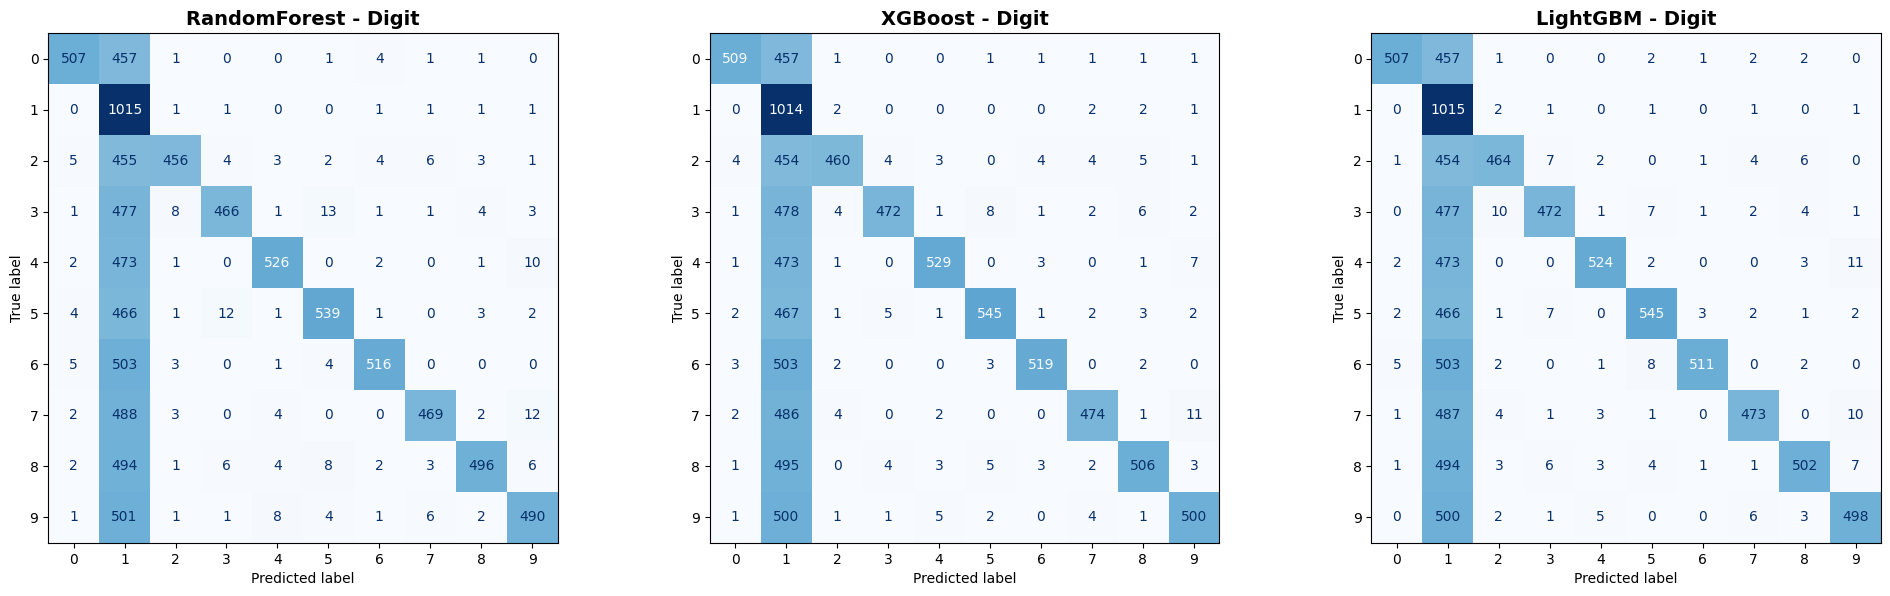

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# 1. 그래프 틀 잡기 (3개 모델 -> 1행 3열)
# 세로 길이(24 -> 6)를 조정하여 1줄에 예쁘게 들어오도록 했습니다.
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
axes = axes.flatten()

print("--- Confusion Matrix 생성 중 ---")

# 2. 저장된 모델 하나씩 꺼내서 평가하기
# 앞선 셀(그레이스케일 학습)에서 제가 드린 코드를 썼다면 'trained_models_gray'에 모델이 있습니다.
# 만약 사용자분 코드를 그대로 썼다면 'trained_models'를 사용하세요.
if 'trained_models_gray' in locals():
    current_models = trained_models_gray
elif 'trained_models' in locals():
    current_models = trained_models
else:
    print("⚠️ 학습된 모델을 찾을 수 없습니다. 모델 학습 셀을 먼저 실행해주세요.")
    current_models = {}

for i, (name, model) in enumerate(current_models.items()):

    # 현재 모델 이름에 따라 적절한 테스트 데이터 선택 (매칭 룰)
    if "Digit" in name:
        X_val = X_val_flat_gray
        y_val = y_val_digit
    else:
        print(f"Skipping {name} (Not a digit model)")
        continue

    # 예측 수행
    y_pred = model.predict(X_val)

    # Confusion Matrix 계산을 위해 정수형으로 변환
    y_val_int = y_val.astype(int)
    y_pred_int = y_pred.astype(int)

    cm = confusion_matrix(y_val_int, y_pred_int)

    # 시각화 (Plot)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)

    # 그래프 그리기
    # 3개만 그리면 되므로 인덱스(i)가 3을 넘지 않도록 주의
    if i < len(axes):
        disp.plot(ax=axes[i], cmap='Blues', values_format='d', colorbar=False)
        axes[i].set_title(f"{name}", fontsize=14, fontweight='bold')

# 레이아웃 깔끔하게 정리
plt.tight_layout()
plt.show()

## HOG Feature 추가 모델 학습

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
import time
from skimage.feature import hog
from tqdm.notebook import tqdm
import numpy as np

def extract_hog_from_binary(images):
    hog_list = []
    # 파라미터: 4x4 cell (이진화된 이미지의 거친 엣지를 세밀하게 포착)
    ppc = 4
    cpb = 2

    for img in tqdm(images, desc="HOG Extraction"):
        # visualize=False -> 벡터만 추출
        feat = hog(img, pixels_per_cell=(ppc, ppc),
                   cells_per_block=(cpb, cpb), visualize=False)
        hog_list.append(feat)
    return np.array(hog_list, dtype=np.float32)

# 사용자가 지정한 변수(X_train_bin, X_val_bin) 사용
print("1. 학습 데이터(X_train_bin) HOG 변환 중...")
X_train_hog = extract_hog_from_binary(X_train_gray)

print("2. 검증 데이터(X_val_bin) HOG 변환 중...")
X_val_hog = extract_hog_from_binary(X_val_gray)

print("3. 증강 all 검증 데이터(X_val_all_bin) HOG 변환 중...")
X_val_all_hog = extract_hog_from_binary(X_val_all_gray)

print("4. 증강 rotate 검증 데이터(X_val_rotate_bin) HOG 변환 중...")
X_val_rotate_hog = extract_hog_from_binary(X_val_rotate_gray)

print("5. 증강 scale 검증 데이터(X_val_scale_bin) HOG 변환 중...")
X_val_scale_hog = extract_hog_from_binary(X_val_scale_gray)

print("6. 장긍 shear 검증 데이터(X_val_shear_bin) HOG 변환 중...")
X_val_shear_hog = extract_hog_from_binary(X_val_shear_gray)

print("7. 증강 shift 검증 데이터(X_val_shift_bin) HOG 변환 중...")
X_val_shift_hog = extract_hog_from_binary(X_val_shift_gray)

print(f"   -> Final HOG Feature Shape: {X_train_hog.shape}")


# --- 2. HOG 피처로 모델 학습 ---
print("\n--- [Step 2] HOG 피처로 모델 학습 시작 ---")

# 나중에 평가를 쉽게 하기 위해 딕셔너리에 저장
trained_models_hog = {}

# --- 2-1. RandomForest with HOG (CPU) ---
# cuRF 대신 sklearn 사용
print("[1/3] RandomForest 모델 학습 중 (HOG)...")
start_time = time.time()
digit_model_rf_hog = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=16, n_jobs=-1)
digit_model_rf_hog.fit(X_train_hog, y_train_digit)
trained_models_hog["RandomForest - HOG"] = digit_model_rf_hog
print(f" -> 학습 완료 (소요 시간: {time.time() - start_time:.2f}초)")

# --- 2-2. XGBoost with HOG (GPU) ---
print("[2/3] XGBoost 모델 학습 중 (HOG)...")
start_time = time.time()
digit_model_xgb_hog = xgb.XGBClassifier(n_estimators=100, random_state=42,
                                        objective='multi:softmax', eval_metric='mlogloss',
                                        num_class=NUM_CLASSES_DIGIT, tree_method='hist', n_jobs = -1)
digit_model_xgb_hog.fit(X_train_hog, y_train_digit)
trained_models_hog["XGBoost - HOG"] = digit_model_xgb_hog
print(f" -> 학습 완료 (소요 시간: {time.time() - start_time:.2f}초)")

# --- 2-3. LightGBM with HOG (CPU) ---
print("[3/3] LightGBM 모델 학습 중 (HOG)...")
start_time = time.time()
digit_model_lgb_hog = lgb.LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1,
                                         objective='multiclass', num_class=NUM_CLASSES_DIGIT, verbose=-1)
digit_model_lgb_hog.fit(X_train_hog, y_train_digit)
trained_models_hog["LightGBM - HOG"] = digit_model_lgb_hog
print(f" -> 학습 완료 (소요 시간: {time.time() - start_time:.2f}초)")

print("\n--- 모든 HOG 모델 학습 완료 ---")

1. 학습 데이터(X_train_bin) HOG 변환 중...


HOG Extraction:   0%|          | 0/60000 [00:00<?, ?it/s]

2. 검증 데이터(X_val_bin) HOG 변환 중...


HOG Extraction:   0%|          | 0/10000 [00:00<?, ?it/s]

3. 증강 all 검증 데이터(X_val_all_bin) HOG 변환 중...


HOG Extraction:   0%|          | 0/10000 [00:00<?, ?it/s]

4. 증강 rotate 검증 데이터(X_val_rotate_bin) HOG 변환 중...


HOG Extraction:   0%|          | 0/10000 [00:00<?, ?it/s]

5. 증강 scale 검증 데이터(X_val_scale_bin) HOG 변환 중...


HOG Extraction:   0%|          | 0/10000 [00:00<?, ?it/s]

6. 장긍 shear 검증 데이터(X_val_shear_bin) HOG 변환 중...


HOG Extraction:   0%|          | 0/10000 [00:00<?, ?it/s]

7. 증강 shift 검증 데이터(X_val_shift_bin) HOG 변환 중...


HOG Extraction:   0%|          | 0/10000 [00:00<?, ?it/s]

   -> Final HOG Feature Shape: (60000, 1296)

--- [Step 2] HOG 피처로 모델 학습 시작 ---
[1/3] RandomForest 모델 학습 중 (HOG)...
 -> 학습 완료 (소요 시간: 32.68초)
[2/3] XGBoost 모델 학습 중 (HOG)...
 -> 학습 완료 (소요 시간: 268.87초)
[3/3] LightGBM 모델 학습 중 (HOG)...


## HOG Feature 추가 모델 성능

In [5]:
def evaluate_model_hog(model_name, model_obj, X_val, y_val):
    print(f"\n===== {model_name} =====")

    y_pred = None
    y_proba = None

    # cuRF (GPU) 처리
    if "cuRF" in model_name:
        import cupy as cp
        X_val_gpu = cp.asarray(X_val)

        # 예측값
        raw_pred = model_obj.predict(X_val_gpu)
        y_pred = raw_pred.get() if hasattr(raw_pred, 'get') else raw_pred

        # 확률값 (AUC용)
        try:
            raw_proba = model_obj.predict_proba(X_val_gpu)
            y_proba = raw_proba.get() if hasattr(raw_proba, 'get') else raw_proba
        except AttributeError:
            y_proba = None
    else:
        # XGBoost, LightGBM
        y_pred = model_obj.predict(X_val)
        try:
            y_proba = model_obj.predict_proba(X_val)
        except AttributeError:
            y_proba = None

    # 결과 출력
    if y_pred is not None:
        print(classification_report(y_val, y_pred, digits=4))
        print(f"   -> Accuracy: {accuracy_score(y_val, y_pred):.4f}")

    if y_proba is not None:
        try:
            auc = roc_auc_score(y_val, y_proba, multi_class='ovr', average='weighted')
            print(f"   -> Weighted AUC: {auc:.4f}")
        except Exception as e:
            print(f"   -> AUC Error: {e}")

print("\n--- 최종 성능 평가 (Validation Set with HOG) ---")

# 학습된 모델들을 순회하며 평가
# 앞선 셀에서 모델 객체들(digit_model_rf_hog 등)이 생성되어 있어야 합니다.
if 'digit_model_rf_hog' in locals():
    print("\n1. 기본 검증 데이터로 평가\n")
    for name, model in trained_models_hog.items():
      evaluate_model_hog(name, model, X_val_hog, y_val_digit)

    print("\n2. 증강 all 검증 데이터로 평가\n")
    for name, model in trained_models_hog.items():
      evaluate_model_hog(name, model, X_val_all_hog, y_val_all_digit)

    print("\n3. 증강 rotate 검증 데이터로 평가\n")
    for name, model in trained_models_hog.items():
      evaluate_model_hog(name, model, X_val_rotate_hog, y_val_rotate_digit)

    print("\n4. 증강 scale 검증 데이터로 평가\n")
    for name, model in trained_models_hog.items():
      evaluate_model_hog(name, model, X_val_scale_hog, y_val_scale_digit)

    print("\n5. 증강 shear 검증 데이터로 평가\n")
    for name, model in trained_models_hog.items():
      evaluate_model_hog(name, model, X_val_shear_hog, y_val_shear_digit)

    print("\n6. 증강 shift 검증 데이터로 평가\n")
    for name, model in trained_models_hog.items():
      evaluate_model_hog(name, model, X_val_shift_hog, y_val_shift_digit)
else:
    print("⚠️ 학습된 HOG 모델을 찾을 수 없습니다. 바로 앞의 'HOG 모델 학습' 셀을 먼저 실행해주세요.")


--- 최종 성능 평가 (Validation Set with HOG) ---

1. 기본 검증 데이터로 평가


===== RandomForest - HOG =====
              precision    recall  f1-score   support

         0.0     0.9828    0.5278    0.6867       972
         1.0     0.1912    0.9951    0.3208      1021
         2.0     0.9838    0.5165    0.6774       939
         3.0     0.9878    0.4995    0.6635       975
         4.0     0.9889    0.5261    0.6868      1015
         5.0     0.9807    0.5432    0.6992      1029
         6.0     0.9943    0.5039    0.6688      1032
         7.0     0.9918    0.4949    0.6603       980
         8.0     0.9868    0.5117    0.6740      1022
         9.0     0.9696    0.5034    0.6628      1015

    accuracy                         0.5633     10000
   macro avg     0.9058    0.5622    0.6400     10000
weighted avg     0.9041    0.5633    0.6393     10000

   -> Accuracy: 0.5633
   -> Weighted AUC: 0.8776

===== XGBoost - HOG =====


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:774: UserWarning: [06:35:27] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


              precision    recall  f1-score   support

         0.0     0.9903    0.5257    0.6868       972
         1.0     0.1914    0.9961    0.3211      1021
         2.0     0.9797    0.5144    0.6746       939
         3.0     0.9839    0.5026    0.6653       975
         4.0     0.9853    0.5291    0.6885      1015
         5.0     0.9894    0.5432    0.7014      1029
         6.0     0.9906    0.5097    0.6731      1032
         7.0     0.9859    0.4980    0.6617       980
         8.0     0.9905    0.5117    0.6748      1022
         9.0     0.9883    0.5015    0.6654      1015

    accuracy                         0.5643     10000
   macro avg     0.9075    0.5632    0.6413     10000
weighted avg     0.9059    0.5643    0.6406     10000

   -> Accuracy: 0.5643
   -> Weighted AUC: 0.8836

===== LightGBM - HOG =====
              precision    recall  f1-score   support

         0.0     0.9847    0.5288    0.6881       972
         1.0     0.1915    0.9971    0.3213      1021


--- Confusion Matrix 생성 중 (HOG Models) ---


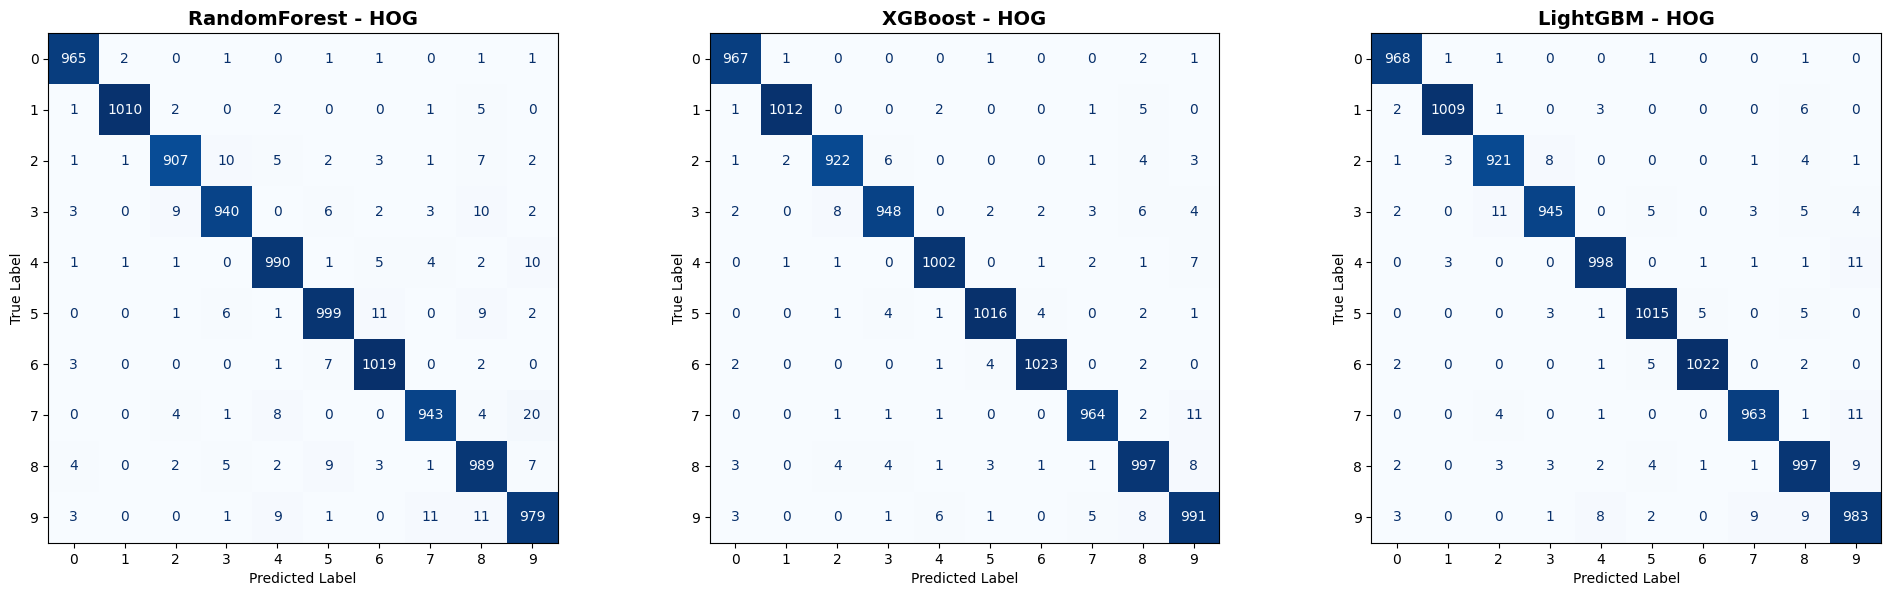

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# 1. 그래프 틀 잡기 (1행 3열)
# 가로로 배치할 것이므로 너비(20)를 넓게, 높이(6)는 적당하게 잡습니다.
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
axes = axes.flatten()

print("--- Confusion Matrix 생성 중 (HOG Models) ---")

# 2. 저장된 모델 확인
if 'trained_models_hog' in locals() and trained_models_hog:
    current_models = trained_models_hog
else:
    print("⚠️ 학습된 HOG 모델(trained_models_hog)이 없습니다. 앞선 학습 셀을 먼저 실행해주세요.")
    current_models = {}

# 3. 모델 순회 및 시각화
for i, (name, model) in enumerate(current_models.items()):

    # [수정] 모델 이름에 "Digit"이 없어도 HOG 모델이면 무조건 그립니다.
    # trained_models_hog에는 이미 HOG 모델만 들어있으므로 조건문이 불필요합니다.
    X_val = X_val_hog
    y_val = y_val_digit

    # 예측 수행
    try:
        y_pred = model.predict(X_val)
    except Exception as e:
        print(f"Error predicting {name}: {e}")
        continue

    # Confusion Matrix 계산
    y_val_int = y_val.astype(int)
    y_pred_int = y_pred.astype(int)

    cm = confusion_matrix(y_val_int, y_pred_int)

    # 시각화 (Plot)
    # 인덱스 범위 체크 (3개까지만 그림)
    if i < len(axes):
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(ax=axes[i], cmap='Blues', values_format='d', colorbar=False)

        # 제목 및 라벨 설정
        axes[i].set_title(f"{name}", fontsize=14, fontweight='bold')
        axes[i].set_xlabel('Predicted Label')
        axes[i].set_ylabel('True Label')

# 레이아웃 정리
plt.tight_layout()
plt.show()

## Hu moments 추가

In [50]:
from skimage.feature import hog
from skimage.measure import moments, moments_central, moments_normalized, moments_hu
import math
import numpy as np
import time
from tqdm.notebook import tqdm

# 모델 라이브러리 임포트
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

# --- 3. [추가] 고급 피처 추출 (HOG + Hu Moments) ---
print("\n--- 고급 피처 추출 시작 (HOG + Hu Moments) ---")
def rgb_to_gray(images):
    """
    images: (N, H, W, 3), 0~1 또는 0~255
    return: (N, H, W) float32 (0~1 스케일)
    """
    if images.max() > 1.0:
        imgs = images.astype(np.float32) / 255.0
    else:
        imgs = images.astype(np.float32)

    #gray = imgs.mean(axis=3)  # (N, H, W), R/G/B 평균 이게 그레이스케일 파라미터 조정
    gray = np.max(imgs, axis=3)
    return gray

print("\n배경 제거된 이미지 Grayscale 변환 중...")

X_val_all_nobg_gray   = rgb_to_gray(X_val_all_nobg)
X_val_rotate_nobg_gray   = rgb_to_gray(X_val_rotate_nobg)
X_val_scale_nobg_gray   = rgb_to_gray(X_val_scale_nobg)
X_val_shear_nobg_gray   = rgb_to_gray(X_val_shear_nobg)
X_val_shift_nobg_gray   = rgb_to_gray(X_val_shift_nobg)
def get_hu_moments(img):
    """이미지에서 7개의 Hu Moments 불변량 추출 (로그 변환 적용)"""
    # 1. 일반 모멘트 계산
    m = moments(img)

    # 2. 무게 중심 계산 (이미지가 0인 경우 예외 처리)
    if m[0, 0] == 0:
        return np.zeros(7)
    cy = m[1, 0] / m[0, 0]
    cx = m[0, 1] / m[0, 0]

    # 3. 중심 모멘트 (이동 불변성)
    mu = moments_central(img, center=(cy, cx))

    # 4. 정규화된 중심 모멘트 (크기 불변성)
    nu = moments_normalized(mu)

    # 5. Hu Moments (회전 불변성)
    hu = moments_hu(nu)

    # 6. 스케일 조정을 위한 로그 변환 (부호 유지)
    for i in range(7):
        if hu[i] != 0:
            hu[i] = -1 * math.copysign(1.0, hu[i]) * math.log10(abs(hu[i]))

    return hu

def extract_advanced_features(images):
    feature_list = []
    # HOG 파라미터 설정
    ppc = 4 # pixels_per_cell
    cpb = 2 # cells_per_block

    print(f"피처 추출 중... (총 {len(images)}개)")
    # skimage는 CPU 연산이므로 tqdm으로 진행상황 표시
    for img in tqdm(images):
        # A. HOG 피처 추출
        hog_feat = hog(img, pixels_per_cell=(ppc, ppc), cells_per_block=(cpb, cpb), visualize=False)

        # B. Hu Moments 추출
        hu_feat = get_hu_moments(img)

        # C. 두 피처 결합 (Concatenate)
        combined = np.hstack([hog_feat, hu_feat])
        feature_list.append(combined)

    return np.array(feature_list, dtype=np.float32)

# 학습 및 검증 데이터에 적용 (데이터 존재 여부 확인)
if 'X_train_gray' in locals() and 'X_val_gray' in locals():
    X_train_features = extract_advanced_features(X_train_gray)
    X_val_features = extract_advanced_features(X_val_gray)
    X_val_all_features = extract_advanced_features(X_val_all_nobg_gray)
    X_val_rotate_features = extract_advanced_features(X_val_rotate_nobg_gray)
    X_val_scale_features = extract_advanced_features(X_val_scale_nobg_gray)
    X_val_shear_features = extract_advanced_features(X_val_shear_nobg_gray)
    X_val_shift_features = extract_advanced_features(X_val_shift_nobg_gray)
    print(f"고급 피처 데이터 Shape: {X_train_features.shape}")
else:
    print("⚠️ 'X_train_gray' 또는 'X_val_gray' 변수가 없습니다. 그레이스케일 변환 셀을 먼저 실행해주세요.")
    X_train_features = None


# --- 4. 고급 피처로 모델 학습 ---
if X_train_features is not None:
    print("\n--- 고급 피처(HOG+Hu) 모델 학습 시작 ---")

    # 학습된 모델을 저장할 딕셔너리
    trained_models_advanced = {}

    # 학습할 모델 목록 정의
    training_jobs_advanced = [
        # 1. RandomForest (CPU)
        # cuRF 대신 sklearn RandomForest 사용
        ("RandomForest - Advanced",
         RandomForestClassifier(n_estimators=100, random_state=42, max_depth=16, n_jobs=-1),
         X_train_features, y_train_digit),

        # 2. XGBoost (GPU)
        # T4 GPU 사용 (device='cuda')
        ("XGBoost - Advanced",
         xgb.XGBClassifier(n_estimators=100, random_state=42,
                           objective='multi:softmax', eval_metric='mlogloss',
                           num_class=NUM_CLASSES_DIGIT, tree_method='hist', n_jobs = -1),
         X_train_features, y_train_digit),

        # 3. LightGBM (CPU)
        # Colab 기본 LightGBM은 GPU 지원이 불안정하므로 CPU 모드 권장
        ("LightGBM - Advanced",
         lgb.LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1,
                            objective='multiclass', num_class=NUM_CLASSES_DIGIT, verbose=-1),
         X_train_features, y_train_digit)
    ]

    # 학습 실행
    for name, model, X_tr, y_tr in tqdm(training_jobs_advanced, desc="Advanced Features Training"):
        start_time = time.time()
        print(f"\n[훈련 중] {name}...")

        model.fit(X_tr, y_tr)

        # 학습된 모델 저장
        trained_models_advanced[name] = model

        print(f" -> {name} 훈련 완료 (소요 시간: {time.time() - start_time:.2f}초)")

    print("--- 고급 피처 모델 학습 완료 ---")


--- 고급 피처 추출 시작 (HOG + Hu Moments) ---

배경 제거된 이미지 Grayscale 변환 중...
피처 추출 중... (총 60000개)


  0%|          | 0/60000 [00:00<?, ?it/s]

피처 추출 중... (총 10000개)


  0%|          | 0/10000 [00:00<?, ?it/s]

피처 추출 중... (총 10000개)


  0%|          | 0/10000 [00:00<?, ?it/s]

피처 추출 중... (총 10000개)


  0%|          | 0/10000 [00:00<?, ?it/s]

피처 추출 중... (총 10000개)


  0%|          | 0/10000 [00:00<?, ?it/s]

피처 추출 중... (총 10000개)


  0%|          | 0/10000 [00:00<?, ?it/s]

피처 추출 중... (총 10000개)


  0%|          | 0/10000 [00:00<?, ?it/s]

고급 피처 데이터 Shape: (60000, 1303)

--- 고급 피처(HOG+Hu) 모델 학습 시작 ---


Advanced Features Training:   0%|          | 0/3 [00:00<?, ?it/s]


[훈련 중] RandomForest - Advanced...
 -> RandomForest - Advanced 훈련 완료 (소요 시간: 43.69초)

[훈련 중] XGBoost - Advanced...
 -> XGBoost - Advanced 훈련 완료 (소요 시간: 26.86초)

[훈련 중] LightGBM - Advanced...
 -> LightGBM - Advanced 훈련 완료 (소요 시간: 216.06초)
--- 고급 피처 모델 학습 완료 ---


## HOG + Humoments 성능 평가

In [51]:
from sklearn.metrics import classification_report, roc_auc_score

def evaluate_model_hoghu(model_name, model_obj, X_val, y_val):
    print(f"\n===== {model_name} =====")

    # 1. 예측 수행
    # cuRF(GPU) 분기를 제거하고, 모든 모델(RF, XGB, LGBM)이
    # Numpy 배열(X_val_features)을 직접 입력받도록 통일했습니다.
    try:
        y_pred = model_obj.predict(X_val)
        y_proba = model_obj.predict_proba(X_val)
    except Exception as e:
        print(f"예측 중 에러 발생 ({model_name}): {e}")
        return

    # 2. 결과 출력
    # 데이터 형변환 (int) - 에러 방지용
    y_val_int = y_val.astype(int)
    y_pred_int = y_pred.astype(int)

    # Classification Report
    print(classification_report(y_val_int, y_pred_int, digits=4))

    # AUC Score
    try:
        auc = roc_auc_score(y_val_int, y_proba, multi_class='ovr', average='weighted')
        print(f"** Weighted-Average AUC: {auc:.4f} **")
    except Exception as e:
        print(f"AUC 계산 중 오류: {e}")

print("\n--- 최종 성능 평가 (Validation Set - Advanced Features) ---")

# 실행 로직
# 1. 데이터(X_val_features)와 모델(trained_models_advanced)이 있는지 확인
if 'trained_models_advanced' in locals() and trained_models_advanced:
    if 'X_val_features' in locals():
        # 딕셔너리에 있는 모든 모델을 순회하며 평가
        print("\n1. 기본 검증 데이터로 평가\n")
        for name, model in trained_models_advanced.items():
            evaluate_model_hoghu(name, model, X_val_features, y_val_digit)
        print("\n2. 증강 all 검증 데이터로 평가\n")
        for name, model in trained_models_advanced.items():
            evaluate_model_hoghu(name, model, X_val_all_features, y_val_all_digit)
        print("\n3. 증강 rotate 검증 데이터로 평가\n")
        for name, model in trained_models_advanced.items():
            evaluate_model_hoghu(name, model, X_val_rotate_features, y_val_rotate_digit)
        print("\n4. 증강 scale 검증 데이터로 평가\n")
        for name, model in trained_models_advanced.items():
            evaluate_model_hoghu(name, model, X_val_scale_features, y_val_scale_digit)
        print("\n5. 증강 shear 검증 데이터로 평가\n")
        for name, model in trained_models_advanced.items():
            evaluate_model_hoghu(name, model, X_val_shear_features, y_val_shear_digit)
        print("\n6. 증강 shift 검증 데이터로 평가\n")
        for name, model in trained_models_advanced.items():
            evaluate_model_hoghu(name, model, X_val_shift_features, y_val_shift_digit)
    else:
        print("❌ 오류: 'X_val_features' 데이터가 없습니다. 피처 추출 셀을 먼저 실행해주세요.")
else:
    print("⚠️ 학습된 고급 피처 모델(trained_models_advanced)이 없습니다. 앞선 '고급 피처 모델 학습' 셀을 먼저 실행해주세요.")




--- 최종 성능 평가 (Validation Set - Advanced Features) ---

1. 기본 검증 데이터로 평가


===== RandomForest - Advanced =====
              precision    recall  f1-score   support

           0     0.9928    0.9990    0.9959       972
           1     0.9980    0.9931    0.9956      1021
           2     0.9863    0.9936    0.9899       939
           3     0.9855    0.9764    0.9809       975
           4     0.9920    0.9813    0.9866      1015
           5     0.9826    0.9864    0.9845      1029
           6     0.9942    0.9903    0.9922      1032
           7     0.9918    0.9898    0.9908       980
           8     0.9863    0.9873    0.9868      1022
           9     0.9796    0.9921    0.9858      1015

    accuracy                         0.9889     10000
   macro avg     0.9889    0.9889    0.9889     10000
weighted avg     0.9889    0.9889    0.9889     10000

** Weighted-Average AUC: 0.9999 **

===== XGBoost - Advanced =====
              precision    recall  f1-score   support

        

--- Confusion Matrix 생성 중 (Advanced Features) ---


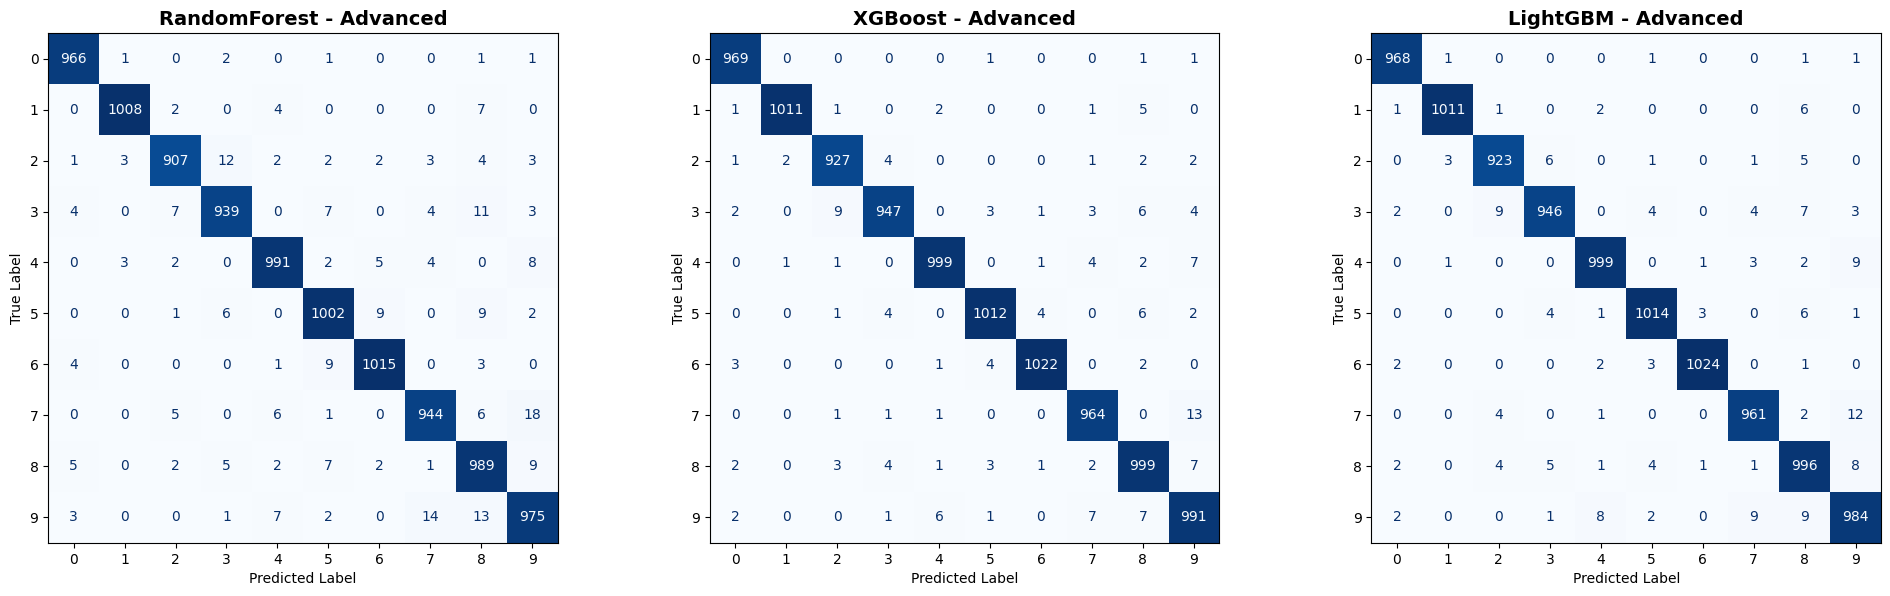

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# =========================================================
# Confusion Matrix 시각화 (Advanced Features)
# =========================================================
print("--- Confusion Matrix 생성 중 (Advanced Features) ---")

# 1. 데이터 및 모델 확인
if 'trained_models_advanced' not in locals() or not trained_models_advanced:
    print("⚠️ 학습된 고급 피처 모델(trained_models_advanced)이 없습니다. 앞선 학습 셀을 먼저 실행해주세요.")
    current_models = {}
elif 'X_val_features' not in locals():
    print("⚠️ 검증 데이터(X_val_features)가 없습니다. 피처 추출 셀을 먼저 실행해주세요.")
    current_models = {}
else:
    current_models = trained_models_advanced

# 2. 그래프 틀 잡기 (1행 3열)
if current_models:
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    axes = axes.flatten()

    for i, (name, model) in enumerate(current_models.items()):

        # 1. 데이터 선택
        # 고급 피처 모델이므로 입력은 X_val_features 입니다.
        X_val = X_val_features
        y_val = y_val_digit

        # 2. 예측 수행
        # cuRF(GPU) 분기 제거 -> 모든 모델이 Numpy 배열을 직접 입력받습니다.
        try:
            y_pred = model.predict(X_val)
        except Exception as e:
            print(f"Error predicting {name}: {e}")
            continue

        # 3. 행렬 계산
        # 정수형 변환 (시각화 에러 방지)
        y_val_int = y_val.astype(int)
        y_pred_int = y_pred.astype(int)

        cm = confusion_matrix(y_val_int, y_pred_int)

        # 4. 시각화 (Plot)
        if i < len(axes):
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)
            # cmap='Blues'로 깔끔하게 표현
            disp.plot(ax=axes[i], cmap='Blues', values_format='d', colorbar=False)

            # 제목 설정
            axes[i].set_title(f"{name}", fontsize=14, fontweight='bold')
            axes[i].set_xlabel('Predicted Label')
            axes[i].set_ylabel('True Label')

    plt.tight_layout()
    plt.show()

In [ ]:
# UMAP 라이브러리 임포트 (설치 안 되어 있을 경우 대비)
try:
    from umap import UMAP
except ImportError:
    !pip install umap-learn
    from umap import UMAP

import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

# --- 1. 공통 임베딩 생성 (Grayscale 데이터 사용!) ---
# Colab CPU 환경에 맞춰 수정
print(">>> 차원 축소 좌표 계산 중 (Validation Set - Grayscale)...")
print("    (CPU 연산이므로 t-SNE 계산에 시간이 조금 걸릴 수 있습니다)")

# 데이터 준비 (GPU 변환 없이 Numpy 배열 바로 사용)
# 앞선 셀에서 X_val_flat_gray가 정의되어 있어야 합니다.
if 'X_val_flat_gray' not in locals():
    print("❌ 오류: 'X_val_flat_gray' 데이터가 없습니다. 그레이스케일 변환 셀을 먼저 실행해주세요.")
else:
    # 1. UMAP
    print("    - UMAP 계산 중...")
    umap_model = UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
    X_umap = umap_model.fit_transform(X_val_flat_gray)

    # 2. t-SNE
    print("    - t-SNE 계산 중...")
    tsne_model = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42, init='pca', learning_rate='auto')
    X_tsne = tsne_model.fit_transform(X_val_flat_gray)

    print(">>> 좌표 계산 완료\n")


    # --- 2. 태스크별 시각화 함수 ---
    def plot_model_predictions_only(task_name, model_dict):
        print(f"--- Viz: {task_name} (Models Only) ---")

        # 해당 태스크(Digit) 모델들 찾기
        models_for_task = {k: v for k, v in model_dict.items() if task_name in k}

        if not models_for_task:
            print(f"⚠️ '{task_name}' 관련 모델을 찾을 수 없습니다.")
            return

        titles = list(models_for_task.keys())
        predictions = []

        for name, model in models_for_task.items():
            # 예측 수행
            # cuRF 분기 제거 -> 모든 모델이 Numpy 입력 가능
            pred = model.predict(X_val_flat_gray)
            predictions.append(pred)

        # 그래프 그리기 (2행 n열)
        n_cols = len(models_for_task)
        fig, axes = plt.subplots(2, n_cols, figsize=(6 * n_cols, 10), constrained_layout=True)

        # 모델이 1개일 경우 axes shape 보정
        if n_cols == 1:
            axes = axes.reshape(2, 1)

        # (Row 1) t-SNE
        for i, (title, y_data) in enumerate(zip(titles, predictions)):
            scatter = axes[0, i].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_data, cmap='tab10', s=1, alpha=0.7)
            axes[0, i].set_title(f"t-SNE: {title}", fontsize=14, fontweight='bold')
            axes[0, i].axis('off')

        # (Row 2) UMAP
        for i, (title, y_data) in enumerate(zip(titles, predictions)):
            scatter = axes[1, i].scatter(X_umap[:, 0], X_umap[:, 1], c=y_data, cmap='tab10', s=1, alpha=0.7)
            axes[1, i].set_title(f"UMAP: {title}", fontsize=14, fontweight='bold')
            axes[1, i].axis('off')

        # 공통 컬러바 (필요 시 주석 해제)
        # cbar = fig.colorbar(scatter, ax=axes[:, :], location='right', shrink=0.6)
        # cbar.set_label(f'{task_name} Predicted Class', fontsize=14)

        plt.suptitle(f"Model Predictions Comparison: {task_name} (Grayscale)", fontsize=22)
        plt.show()

    # --- 3. 전체 실행 ---
    # 그레이스케일 학습 모델들은 'trained_models_gray' 딕셔너리에 저장되어 있다고 가정합니다.
    if 'trained_models_gray' in locals():
        target_models = trained_models_gray
    elif 'trained_models' in locals():
        target_models = trained_models
    else:
        target_models = {}
        print("⚠️ 학습된 모델 딕셔너리를 찾을 수 없습니다.")

    # 숫자 분류 (Digit) 시각화
    plot_model_predictions_only("Digit", target_models)

## 그레이스케일 파라미터 조정

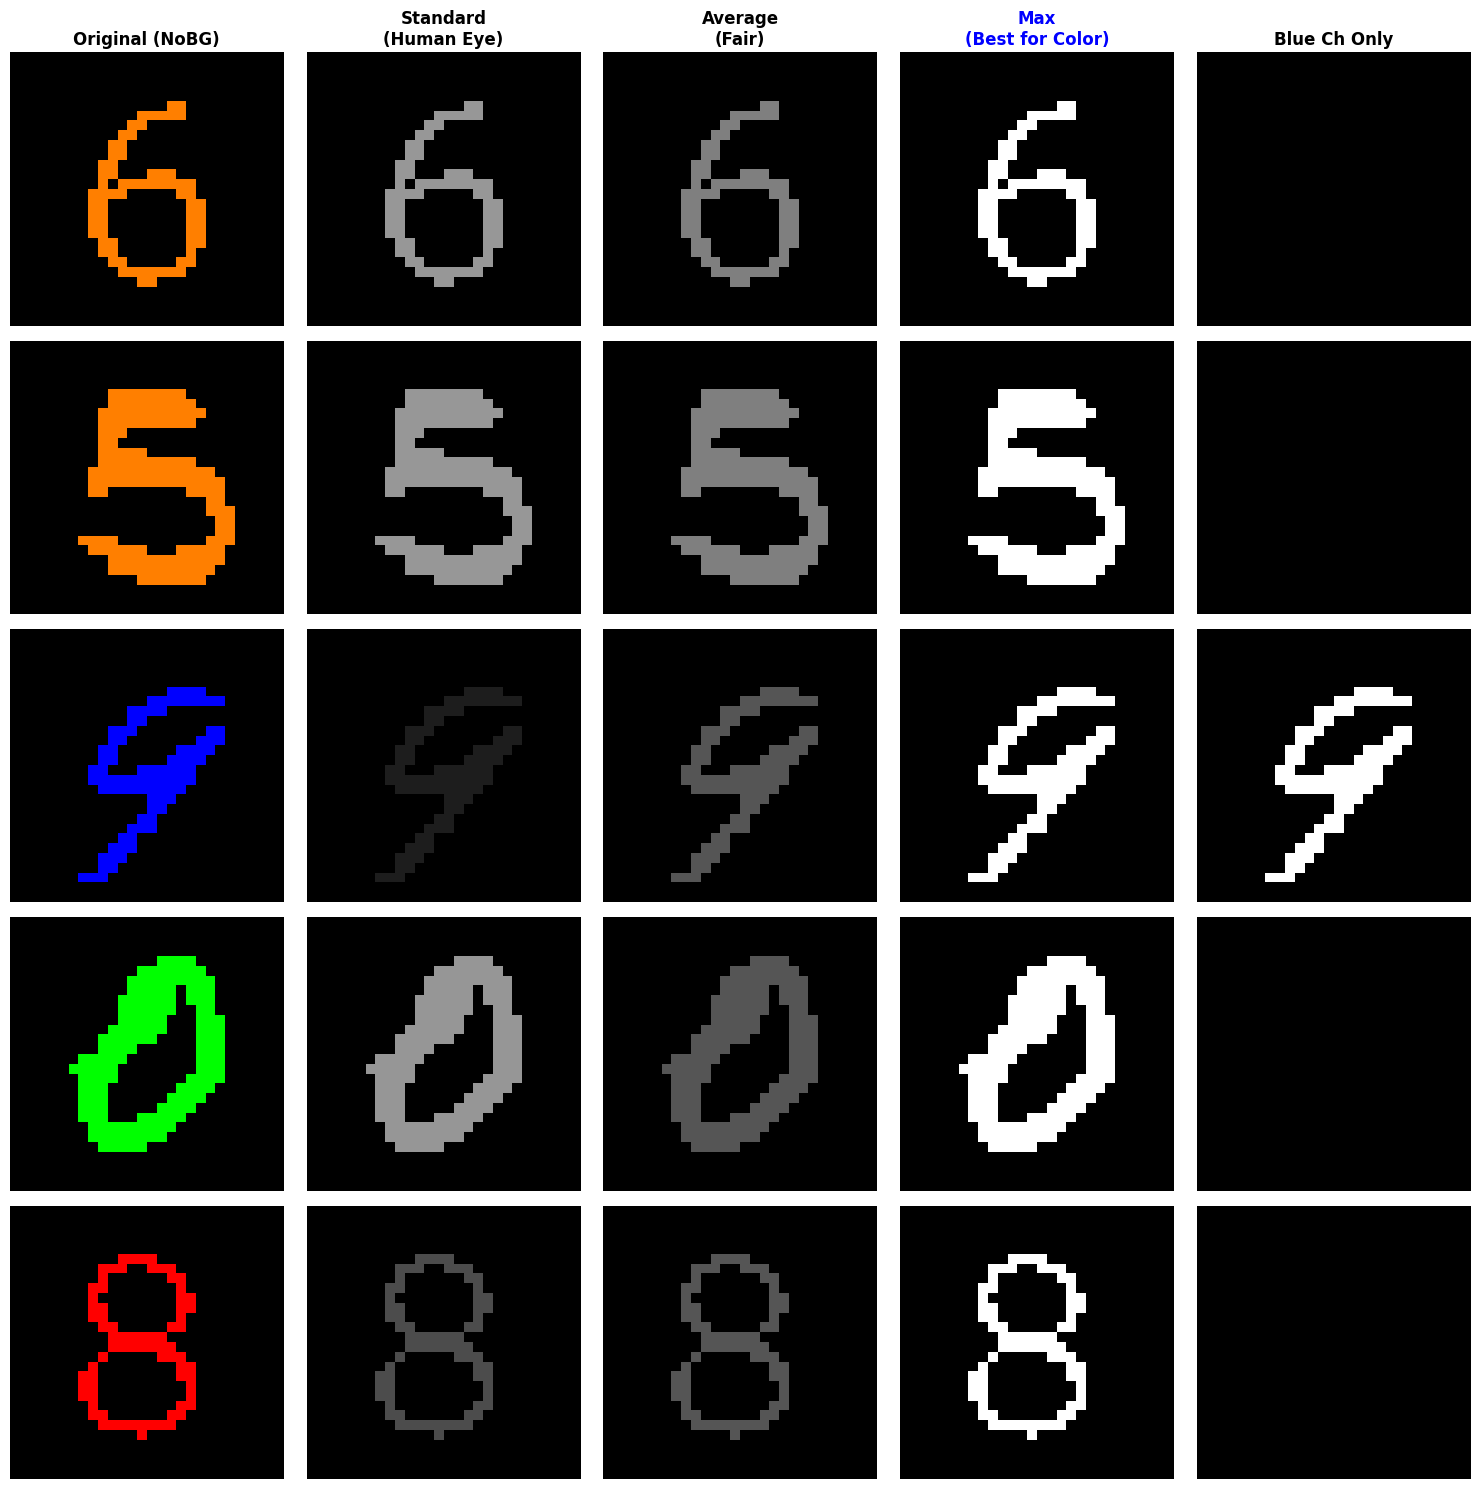

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def compare_grayscale_methods(images_rgb, num_samples=5):
    print(f"그레이스케일 변환 비교 (샘플 {num_samples}개)...")

    # 랜덤 샘플 추출
    # 데이터 개수가 num_samples보다 적을 경우를 대비해 min 사용
    n_total = len(images_rgb)
    if n_total < num_samples:
        num_samples = n_total

    idx = np.random.choice(n_total, num_samples, replace=False)
    samples = images_rgb[idx]

    # 1. Standard (0.299R + 0.587G + 0.114B)
    gray_std = np.dot(samples[...,:3], [0.299, 0.587, 0.114])

    # 2. Average ((R+G+B)/3)
    gray_avg = np.mean(samples[...,:3], axis=3)

    # 3. Max (max(R, G, B)) - 색상에 상관없이 가장 밝은 값
    gray_max = np.max(samples[...,:3], axis=3)

    # 4. Blue Channel Only (파란색 성분만 보기)
    # 파란색 숫자가 Standard에서 얼마나 어두워지는지 비교용
    gray_blue = samples[..., 2]

    # 시각화
    fig, axes = plt.subplots(num_samples, 5, figsize=(15, 3 * num_samples))

    titles = ["Original (NoBG)", "Standard\n(Human Eye)", "Average\n(Fair)", "Max\n(Best for Color)", "Blue Ch Only"]

    for i in range(num_samples):
        # 1행만 있을 경우 axes가 1차원 배열이 되므로 처리 필요
        if num_samples == 1:
            ax_row = axes
        else:
            ax_row = axes[i]

        # Original
        ax_row[0].imshow(samples[i])
        ax_row[0].axis('off')
        if i == 0: ax_row[0].set_title(titles[0], fontweight='bold')

        # Standard
        ax_row[1].imshow(gray_std[i], cmap='gray', vmin=0, vmax=1)
        ax_row[1].axis('off')
        if i == 0: ax_row[1].set_title(titles[1], fontweight='bold')

        # Average
        ax_row[2].imshow(gray_avg[i], cmap='gray', vmin=0, vmax=1)
        ax_row[2].axis('off')
        if i == 0: ax_row[2].set_title(titles[2], fontweight='bold')

        # Max
        ax_row[3].imshow(gray_max[i], cmap='gray', vmin=0, vmax=1)
        ax_row[3].axis('off')
        if i == 0: ax_row[3].set_title(titles[3], fontweight='bold', color='blue')

        # Blue
        ax_row[4].imshow(gray_blue[i], cmap='gray', vmin=0, vmax=1)
        ax_row[4].axis('off')
        if i == 0: ax_row[4].set_title(titles[4], fontweight='bold')

    plt.tight_layout()
    plt.show()

# 배경이 제거된 RGB 데이터(X_train_nobg)가 있는지 확인 후 실행
if 'X_train_nobg' in locals():
    compare_grayscale_methods(X_train_nobg)
else:
    print("⚠️ 'X_train_nobg' 변수를 찾을 수 없습니다. 배경 제거 코드를 먼저 실행해주세요.")

## 그레이스케일 작업

배경 제거된 데이터 Flatten 작업 시작...
색상 분류용 데이터 (배경제거 Color): (60000, 2352)

배경 제거된 이미지 Grayscale 변환 중...
배경제거+Grayscale 학습 데이터 Shape: (60000, 28, 28)
배경제거+Grayscale 검증 데이터 Shape: (10000, 28, 28)
배경제거+Grayscale Flatten Shape (Train, Val): (60000, 784) (10000, 784)


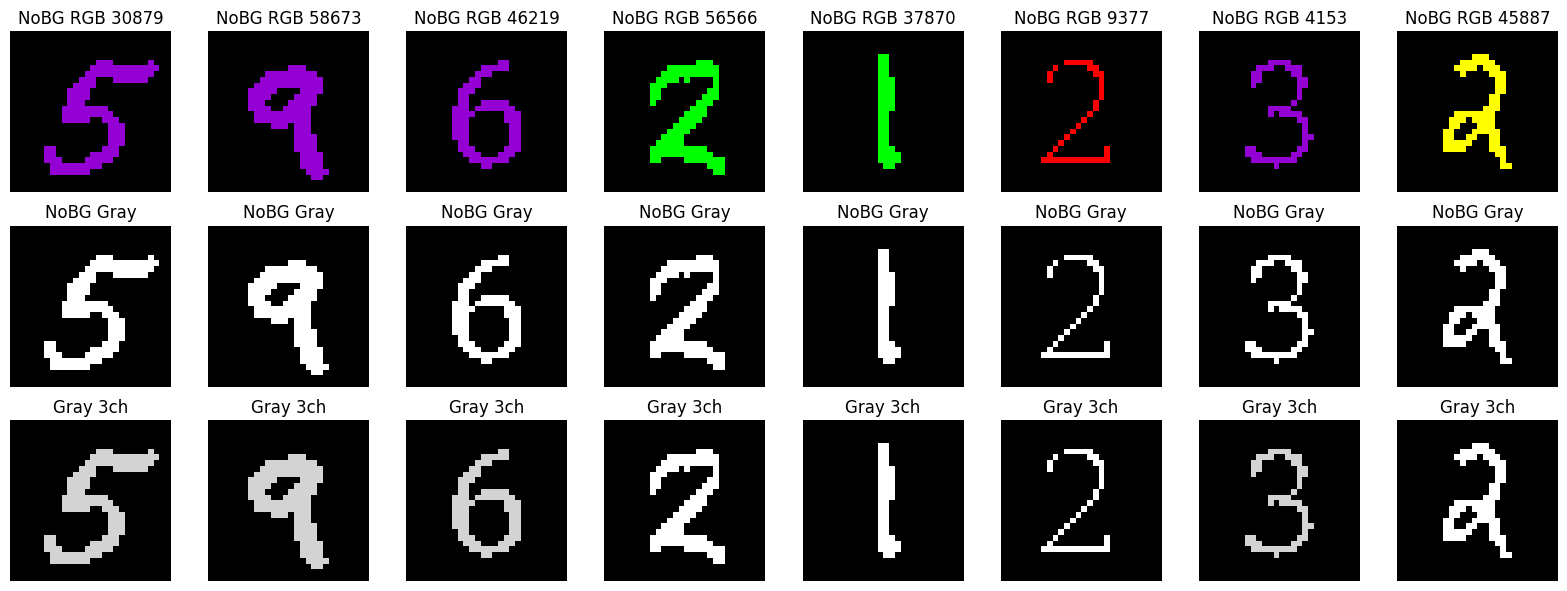

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. 배경 제거 데이터 Flatten ---
# (앞선 셀에서 X_train_nobg 등이 생성되어 있어야 합니다)
if 'X_train_nobg' in locals():
    print("배경 제거된 데이터 Flatten 작업 시작...")

    X_train_flat_nobg = X_train_nobg.reshape(X_train_nobg.shape[0], -1)
    X_val_flat_nobg   = X_val_nobg.reshape(X_val_nobg.shape[0], -1)

    # 추가 검증 데이터셋 (존재 여부 확인 후 처리)
    if 'X_val_all_nobg' in locals(): X_val_all_flat_nobg = X_val_all_nobg.reshape(X_val_all_nobg.shape[0], -1)
    if 'X_val_rotate_nobg' in locals(): X_val_rotate_flat_nobg = X_val_rotate_nobg.reshape(X_val_rotate_nobg.shape[0], -1)
    if 'X_val_scale_nobg' in locals(): X_val_scale_flat_nobg = X_val_scale_nobg.reshape(X_val_scale_nobg.shape[0], -1)
    if 'X_val_shear_nobg' in locals(): X_val_shear_flat_nobg = X_val_shear_nobg.reshape(X_val_shear_nobg.shape[0], -1)
    if 'X_val_shift_nobg' in locals(): X_val_shift_flat_nobg = X_val_shift_nobg.reshape(X_val_shift_nobg.shape[0], -1)

    print(f"색상 분류용 데이터 (배경제거 Color): {X_train_flat_nobg.shape}")
else:
    print("❌ 'X_train_nobg' 데이터가 없습니다. 배경 제거 코드를 먼저 실행해주세요.")


# ===============================
# 5. 배경 제거 후 Grayscale 변환 (Digit 전용)
# ===============================
def rgb_to_gray(images):
    """
    images: (N, H, W, 3), 0~1 또는 0~255
    return: (N, H, W) float32 (0~1 스케일)
    """
    if images.max() > 1.0:
        imgs = images.astype(np.float32) / 255.0
    else:
        imgs = images.astype(np.float32)

    # [중요] 사용자가 선택한 방식: np.max (색상 중 가장 밝은 값 사용)
    # 글씨가 노란색(R+G)이든 파란색(B)이든 밝게 살리기 위해 max가 유리할 수 있습니다.
    gray = np.max(imgs, axis=3)
    return gray

if 'X_train_nobg' in locals():
    print("\n배경 제거된 이미지 Grayscale 변환 중...")
    X_train_nobg_gray = rgb_to_gray(X_train_nobg)
    X_val_nobg_gray   = rgb_to_gray(X_val_nobg)

    # 증강 데이터셋 변환 (존재하는 경우만)
    if 'X_val_all_nobg' in locals(): X_val_all_nobg_gray = rgb_to_gray(X_val_all_nobg)
    if 'X_val_rotate_nobg' in locals(): X_val_rotate_nobg_gray = rgb_to_gray(X_val_rotate_nobg)
    if 'X_val_scale_nobg' in locals(): X_val_scale_nobg_gray = rgb_to_gray(X_val_scale_nobg)
    if 'X_val_shear_nobg' in locals(): X_val_shear_nobg_gray = rgb_to_gray(X_val_shear_nobg)
    if 'X_val_shift_nobg' in locals(): X_val_shift_nobg_gray = rgb_to_gray(X_val_shift_nobg)

    print("배경제거+Grayscale 학습 데이터 Shape:", X_train_nobg_gray.shape)
    print("배경제거+Grayscale 검증 데이터 Shape:", X_val_nobg_gray.shape)

    # Flatten (Digit 전용 입력)
    X_train_flat_nobg_gray = X_train_nobg_gray.reshape(X_train_nobg_gray.shape[0], -1)
    X_val_flat_nobg_gray   = X_val_nobg_gray.reshape(X_val_nobg_gray.shape[0], -1)

    if 'X_val_all_nobg_gray' in locals(): X_val_all_flat_nobg_gray = X_val_all_nobg_gray.reshape(X_val_all_nobg_gray.shape[0], -1)
    if 'X_val_rotate_nobg_gray' in locals(): X_val_rotate_flat_nobg_gray = X_val_rotate_nobg_gray.reshape(X_val_rotate_nobg_gray.shape[0], -1)
    if 'X_val_scale_nobg_gray' in locals(): X_val_scale_flat_nobg_gray = X_val_scale_nobg_gray.reshape(X_val_scale_nobg_gray.shape[0], -1)
    if 'X_val_shear_nobg_gray' in locals(): X_val_shear_flat_nobg_gray = X_val_shear_nobg_gray.reshape(X_val_shear_nobg_gray.shape[0], -1)
    if 'X_val_shift_nobg_gray' in locals(): X_val_shift_flat_nobg_gray = X_val_shift_nobg_gray.reshape(X_val_shift_nobg_gray.shape[0], -1)

    print("배경제거+Grayscale Flatten Shape (Train, Val):", X_train_flat_nobg_gray.shape, X_val_flat_nobg_gray.shape)


    # ===============================
    # 6. 배경제거 + Grayscale 결과 시각화 (샘플 8개)
    # ===============================
    num_samples = 8
    idx_gray = np.random.choice(X_train_nobg_gray.shape[0], num_samples, replace=False)

    plt.figure(figsize=(16, 6))

    for col, i in enumerate(idx_gray):
        # (1) 배경제거된 RGB 이미지
        ax1 = plt.subplot(3, num_samples, col + 1)
        ax1.imshow(X_train_nobg[i])
        ax1.axis('off')
        ax1.set_title(f"NoBG RGB {i}")

        # (2) Grayscale 이미지
        ax2 = plt.subplot(3, num_samples, num_samples + col + 1)
        ax2.imshow(X_train_nobg_gray[i], cmap='gray')
        ax2.axis('off')
        ax2.set_title("NoBG Gray")

        # (3) Grayscale 단일 채널을 3채널로 확장하여 확인 (선택적)
        ax3 = plt.subplot(3, num_samples, 2*num_samples + col + 1)
        ax3.imshow(np.repeat(X_train_nobg_gray[i][:,:,None], 3, axis=2), cmap='gray')
        ax3.axis('off')
        ax3.set_title("Gray 3ch")

    plt.tight_layout()
    plt.show()

## 배경제거+그레이스케일+이진화


Grayscale 이미지 이진화 적용 중 (Threshold=0.5)...
이진화 학습 데이터 Shape: (60000, 28, 28)
이진화 검증 데이터 Shape: (10000, 28, 28)
이진화 증강 검증 데이터 (all, rotate, scale, shear, shift): (10000, 28, 28) (10000, 28, 28) (10000, 28, 28) (10000, 28, 28) (10000, 28, 28)
이진화 Flatten Shape: (60000, 784)
이진화 증강 검증 데이터 flatten (all, rotate, scale, shear, shift): (10000, 784) (10000, 784) (10000, 784) (10000, 784) (10000, 784)


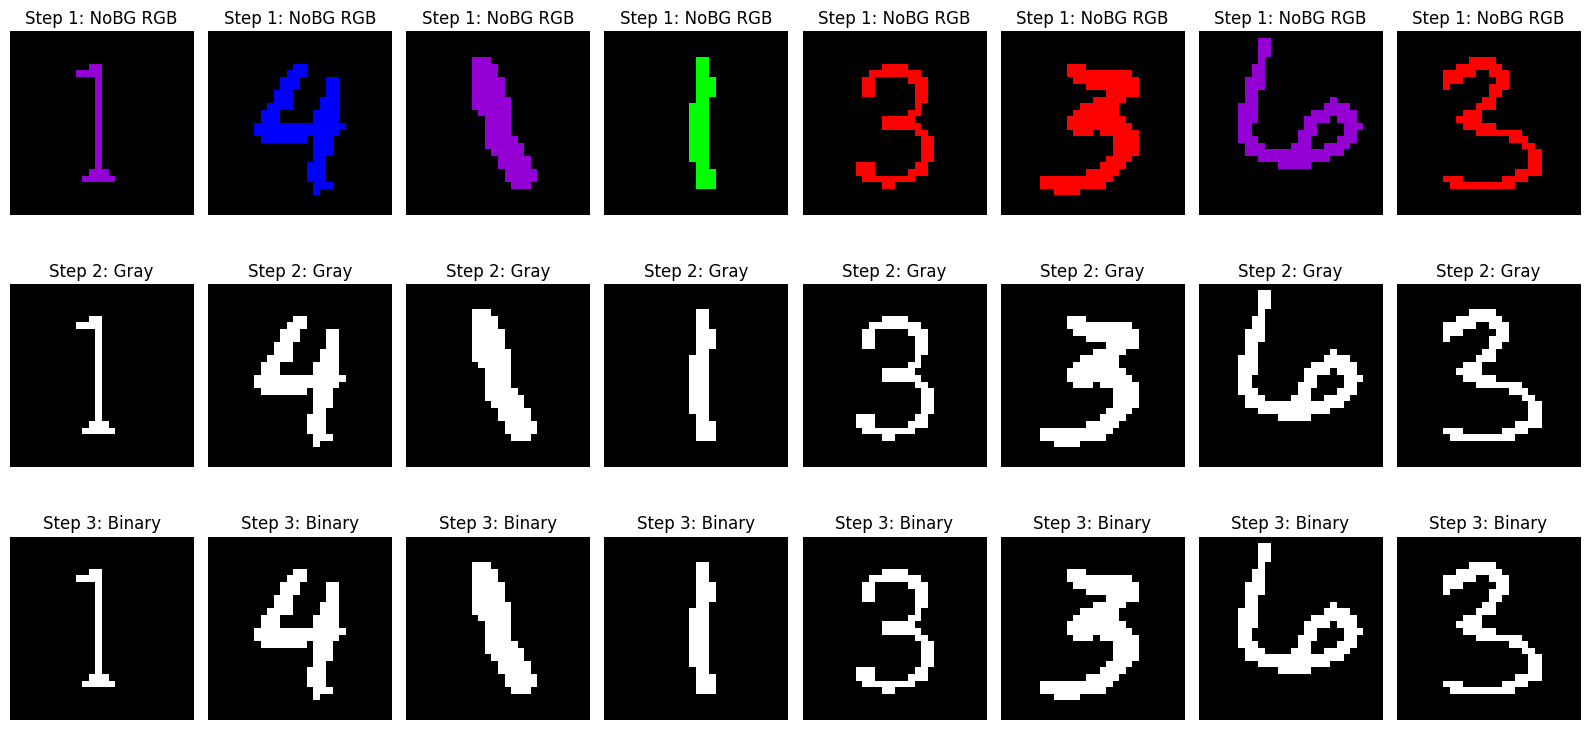

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ===============================
# 7. Grayscale -> Binarization (이진화)
# ===============================
# 앞선 셀에서 X_train_nobg_gray 등이 생성되어 있어야 합니다.
if 'X_train_nobg_gray' in locals():
    # 임계값 (Threshold) 설정
    THRESHOLD = 0.5
    print(f"\nGrayscale 이미지 이진화 적용 중 (Threshold={THRESHOLD})...")

    # 1. 기본 데이터 이진화
    X_train_bin = (X_train_nobg_gray > THRESHOLD).astype(np.float32)
    X_val_bin   = (X_val_nobg_gray > THRESHOLD).astype(np.float32)

    print("이진화 학습 데이터 Shape:", X_train_bin.shape)
    print("이진화 검증 데이터 Shape:", X_val_bin.shape)

    # 2. 증강 데이터 이진화 (변수가 존재하는 경우에만 수행)
    if 'X_val_all_nobg_gray' in locals():
        X_val_all_bin = (X_val_all_nobg_gray > THRESHOLD).astype(np.float32)
        print("이진화 증강 검증 데이터(all) Shape:", X_val_all_bin.shape)

    if 'X_val_rotate_nobg_gray' in locals(): X_val_rotate_bin = (X_val_rotate_nobg_gray > THRESHOLD).astype(np.float32)
    if 'X_val_scale_nobg_gray' in locals(): X_val_scale_bin = (X_val_scale_nobg_gray > THRESHOLD).astype(np.float32)
    if 'X_val_shear_nobg_gray' in locals(): X_val_shear_bin = (X_val_shear_nobg_gray > THRESHOLD).astype(np.float32)
    if 'X_val_shift_nobg_gray' in locals(): X_val_shift_bin = (X_val_shift_nobg_gray > THRESHOLD).astype(np.float32)

    # 3. Flatten (모델 입력용)
    X_train_flat_bin = X_train_bin.reshape(X_train_bin.shape[0], -1)
    X_val_flat_bin   = X_val_bin.reshape(X_val_bin.shape[0], -1)

    if 'X_val_all_bin' in locals(): X_val_all_flat_bin = X_val_all_bin.reshape(X_val_all_bin.shape[0], -1)
    if 'X_val_rotate_bin' in locals(): X_val_rotate_flat_bin = X_val_rotate_bin.reshape(X_val_rotate_bin.shape[0], -1)
    if 'X_val_scale_bin' in locals(): X_val_scale_flat_bin = X_val_scale_bin.reshape(X_val_scale_bin.shape[0], -1)
    if 'X_val_shear_bin' in locals(): X_val_shear_flat_bin = X_val_shear_bin.reshape(X_val_shear_bin.shape[0], -1)
    if 'X_val_shift_bin' in locals(): X_val_shift_flat_bin = X_val_shift_bin.reshape(X_val_shift_bin.shape[0], -1)

    print("이진화 Flatten Shape:", X_train_flat_bin.shape)


    # ===============================
    # 8. 전체 변환 과정 시각화 (RGB -> Gray -> Binary)
    # ===============================
    # 시각화할 샘플 인덱스 설정
    if 'idx_gray' not in locals():
        num_samples = 8
        idx_gray = np.random.choice(X_train_nobg_gray.shape[0], num_samples, replace=False)
    else:
        num_samples = len(idx_gray)

    plt.figure(figsize=(16, 8)) # 3줄 표현

    for col, i in enumerate(idx_gray):
        # (1) 배경제거 RGB (1행)
        ax1 = plt.subplot(3, num_samples, col + 1)
        if 'X_train_nobg' in locals():
            ax1.imshow(X_train_nobg[i])
        ax1.axis('off')
        ax1.set_title("Step 1: NoBG RGB")

        # (2) Grayscale (2행)
        ax2 = plt.subplot(3, num_samples, num_samples + col + 1)
        ax2.imshow(X_train_nobg_gray[i], cmap='gray')
        ax2.axis('off')
        ax2.set_title("Step 2: Gray")

        # (3) Binarization (3행)
        ax3 = plt.subplot(3, num_samples, 2 * num_samples + col + 1)
        ax3.imshow(X_train_bin[i], cmap='gray')
        ax3.axis('off')
        ax3.set_title(f"Step 3: Binary")

    plt.tight_layout()
    plt.show()

else:
    print("❌ 'X_train_nobg_gray' 데이터가 없습니다. 바로 앞의 '그레이스케일 변환' 셀을 먼저 실행해주세요.")

## 변환과정 확인

새로 뽑은 이미지 인덱스: [58336 58419 47450 28826 10213  5538 28922  2685]


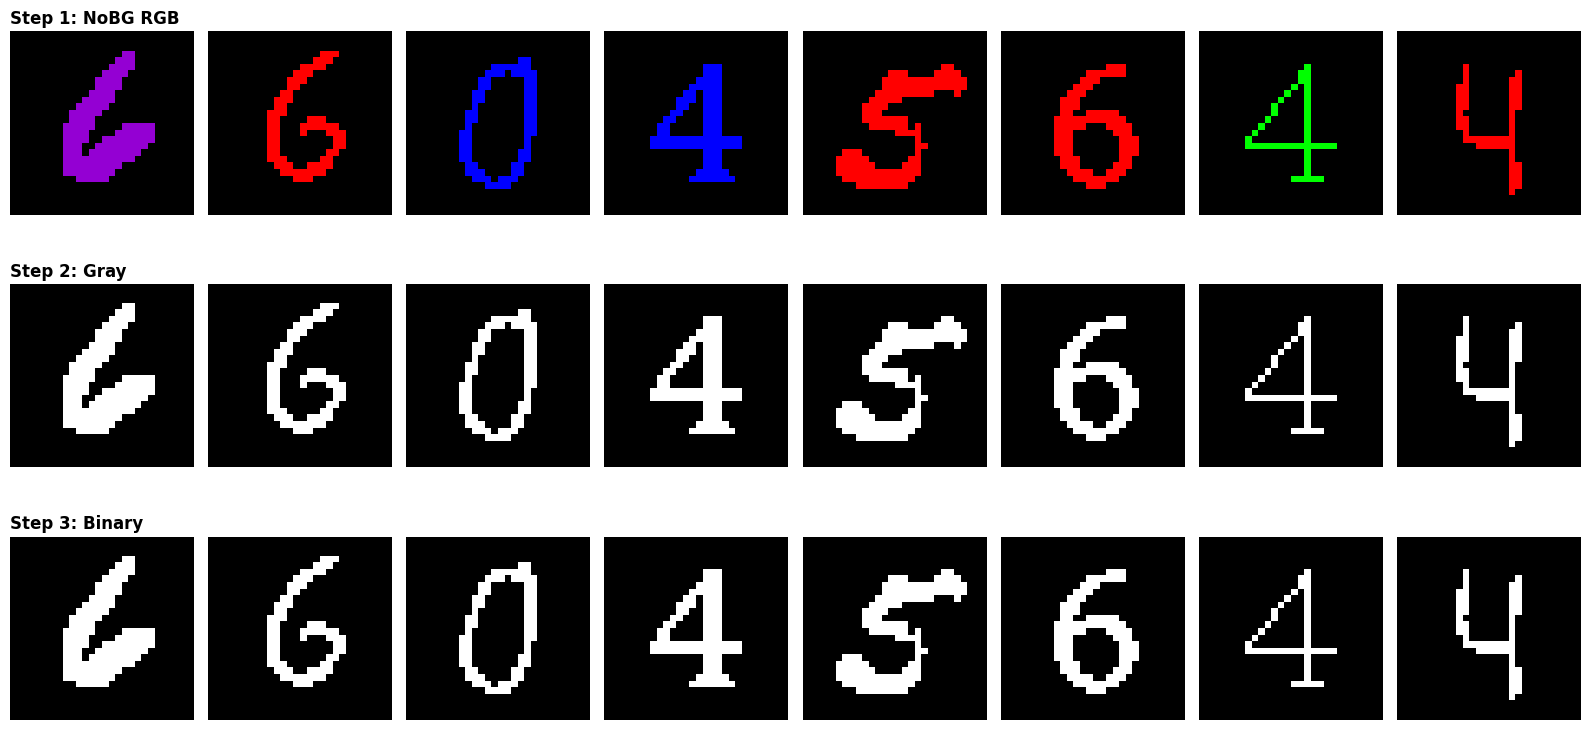

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ===============================
# 8. 전체 변환 과정 시각화 (매번 새로운 이미지)
# ===============================

# 데이터가 존재하는지 확인
if 'X_train_nobg_gray' in locals() and 'X_train_nobg' in locals() and 'X_train_bin' in locals():

    # 1. 매번 실행할 때마다 새로운 랜덤 인덱스 8개 뽑기
    num_samples = 8
    # 전체 데이터 개수 범위 내에서 무작위 추출
    random_indices = np.random.choice(len(X_train_nobg_gray), num_samples, replace=False)

    print(f"새로 뽑은 이미지 인덱스: {random_indices}")

    plt.figure(figsize=(16, 8)) # 3줄 표현 (배경제거 RGB -> Gray -> Binary)

    for col, i in enumerate(random_indices):
        # (1) 배경제거 RGB (1행)
        ax1 = plt.subplot(3, num_samples, col + 1)
        ax1.imshow(X_train_nobg[i])
        ax1.axis('off')
        if col == 0: ax1.set_title("Step 1: NoBG RGB", fontsize=12, fontweight='bold', loc='left')

        # (2) Grayscale (2행)
        ax2 = plt.subplot(3, num_samples, num_samples + col + 1)
        ax2.imshow(X_train_nobg_gray[i], cmap='gray')
        ax2.axis('off')
        if col == 0: ax2.set_title("Step 2: Gray", fontsize=12, fontweight='bold', loc='left')

        # (3) Binarization (3행)
        ax3 = plt.subplot(3, num_samples, 2 * num_samples + col + 1)
        ax3.imshow(X_train_bin[i], cmap='gray')
        ax3.axis('off')
        if col == 0: ax3.set_title("Step 3: Binary", fontsize=12, fontweight='bold', loc='left')

    plt.tight_layout()
    plt.show()

else:
    print("❌ 필요한 데이터(X_train_nobg, X_train_bin 등)가 없습니다. 이전 전처리 단계들을 먼저 실행해주세요.")

## 배경제거+그레이스케일 픽셀 밝기 분포 확인

픽셀 밝기 분포 분석 중...


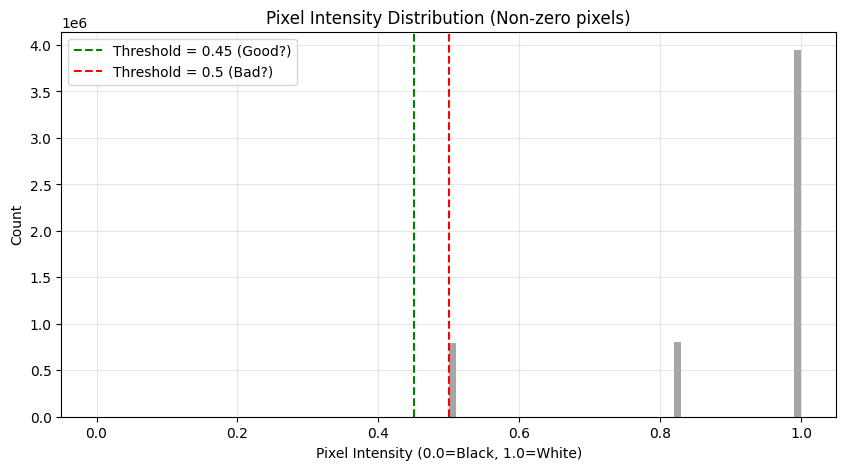

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_pixel_histogram(images, sample_count=60000):
    """
    이미지 픽셀 밝기 분포(Histogram)를 그려서 최적의 Threshold를 찾습니다.
    """
    # 데이터 개수보다 샘플 수가 많으면 전체 사용
    if len(images) < sample_count:
        sample_count = len(images)

    print(f"픽셀 밝기 분포 분석 중 (샘플 {sample_count}개)...")

    # 샘플링
    idx = np.random.choice(len(images), sample_count, replace=False)
    sampled_imgs = images[idx]

    # 모든 픽셀을 1차원으로 쫘악 펴기
    pixel_values = sampled_imgs.flatten()

    # 0(완전 검은 배경)은 너무 많아서 그래프를 망치므로 제외하고,
    # 0보다 큰 값(글씨+노이즈)만 봅니다.
    # 노이즈를 고려해 0.01보다 큰 값만 봅니다.
    pixel_values_nonzero = pixel_values[pixel_values > 0.01]

    plt.figure(figsize=(10, 5))
    # bins를 100개로 나누어 정밀하게 봅니다.
    plt.hist(pixel_values_nonzero, bins=100, range=(0.0, 1.0), color='gray', alpha=0.7)

    # 사용자가 고민했던 지점 표시 (이진화 기준선)
    plt.axvline(0.45, color='green', linestyle='--', label='Threshold = 0.45 (Candidate)')
    plt.axvline(0.5, color='red', linestyle='--', label='Threshold = 0.5 (Default)')

    plt.title("Pixel Intensity Distribution (Non-zero pixels)")
    plt.xlabel("Pixel Intensity (0.0=Black, 1.0=White)")
    plt.ylabel("Count")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# 배경제거+그레이스케일 된 데이터(X_train_nobg_gray)를 넣어보세요
if 'X_train_nobg_gray' in locals():
    # 전체 6만장을 다 그리면 느릴 수 있으므로 1만장 정도로 줄여서 확인해도 충분합니다.
    plot_pixel_histogram(X_train_nobg_gray, sample_count=10000)
else:
    print("❌ 'X_train_nobg_gray' 데이터가 없습니다. 그레이스케일 변환 셀을 먼저 실행해주세요.")

>>> 전체 데이터 60000장의 0.1 ~ 0.3 구간 정밀 분석 중...
   -> 해당 구간 픽셀 수: 798,423개


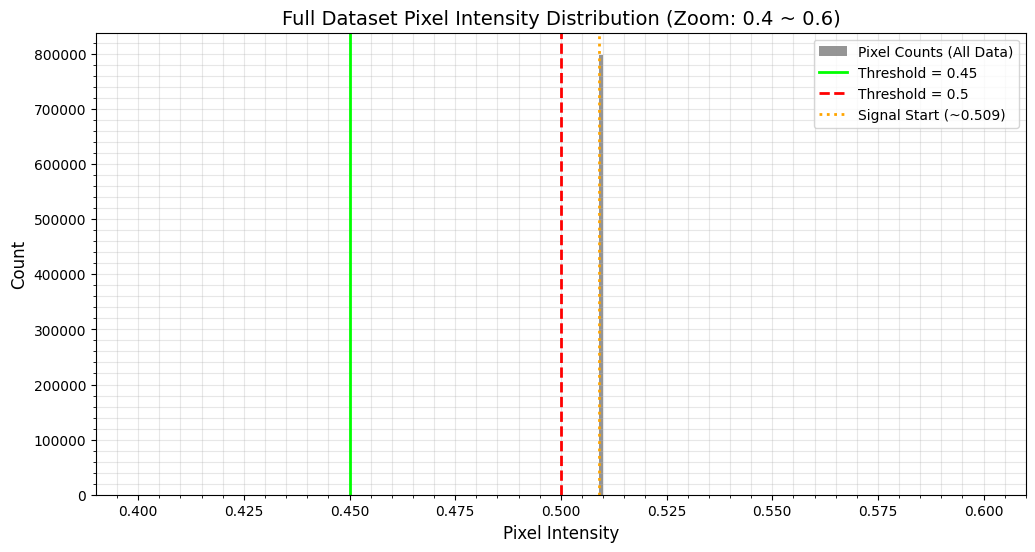

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_zoomed_histogram_all(images):
    """
    샘플링 없이 전체 데이터(60,000장)의 0.4 ~ 0.6 구간 픽셀 분포를 정밀하게 확인합니다.
    """
    print(f">>> 전체 데이터 {len(images)}장의 0.4 ~ 0.6 구간 정밀 분석 중...")

    # 1. 샘플링 과정 생략 -> 전체 데이터를 1차원으로 펼치기
    # (N, 28, 28) -> (N * 784,)
    # 메모리 효율을 위해 필요한 데이터만 복사하거나 바로 마스킹 할 수도 있지만,
    # flatten()은 사본을 만드므로 메모리가 넉넉한지 주의해야 합니다.
    # Colab 표준 런타임(RAM 12GB)에서는 6만장(약 47MB) flatten은 충분히 가능합니다.
    pixel_values = images.flatten()

    # 2. 0.4 ~ 0.6 사이 값만 필터링 (메모리 절약 및 속도 향상)
    # 전체 4700만 개 픽셀 중 해당 구간만 남깁니다.
    zoom_range_mask = (pixel_values >= 0.4) & (pixel_values <= 0.6)
    pixel_values_zoomed = pixel_values[zoom_range_mask]

    print(f"   -> 해당 구간 픽셀 수: {len(pixel_values_zoomed):,}개")

    if len(pixel_values_zoomed) == 0:
        print("⚠️ 해당 구간(0.4 ~ 0.6)에 픽셀이 하나도 없습니다. 구간을 조정해보세요.")
        return

    plt.figure(figsize=(12, 6))

    # 3. 히스토그램 그리기
    # bins=200으로 더 잘게 쪼개서 0.001 단위의 변화까지 봅니다.
    counts, _, _ = plt.hist(pixel_values_zoomed, bins=200, range=(0.4, 0.6),
                            color='dimgray', alpha=0.7, label='Pixel Counts (All Data)')

    # 주요 지점 표시
    plt.axvline(0.45, color='lime', linestyle='-', linewidth=2, label='Threshold = 0.45')
    plt.axvline(0.5, color='red', linestyle='--', linewidth=2, label='Threshold = 0.5')

    # 0.509 지점 강조 (사용자 지정: 신호 시작점 추정)
    plt.axvline(0.509, color='orange', linestyle=':', linewidth=2, label='Signal Start (~0.509)')

    plt.title(f"Full Dataset Pixel Intensity Distribution (Zoom: 0.4 ~ 0.6)", fontsize=14)
    plt.xlabel("Pixel Intensity", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3, which='both')
    plt.minorticks_on()

    plt.show()

# 전체 데이터(X_train_nobg_gray)를 넣어서 실행하세요
if 'X_train_nobg_gray' in locals():
    plot_zoomed_histogram_all(X_train_nobg_gray)
else:
    print("❌ 'X_train_nobg_gray' 데이터가 없습니다. 그레이스케일 변환 셀을 먼저 실행해주세요.")

## 배경제거+그레이스케일 학습

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from tqdm.notebook import tqdm

print("\n--- 3종 모델 학습 시작 (배경제거+Grayscale, Digit 전용) ---")

# 학습할 모델 리스트 정의
training_jobs_nobg_gray = [
    # 1. RandomForest - Digit (CPU)
    # cuRF 대신 sklearn의 RandomForestClassifier 사용
    ("RandomForest - Digit (NoBG+Gray)",
     RandomForestClassifier(n_estimators=100, max_depth=16, random_state=42, n_jobs=-1),
     X_train_flat_nobg_gray, y_train_digit),

    # 2. XGBoost - Digit (GPU)
    # Colab T4 GPU 사용
    ("XGBoost - Digit (NoBG+Gray)",
     xgb.XGBClassifier(
         n_estimators=100, tree_method='hist', n_jobs = -1,
            objective='multi:softmax', num_class=10, random_state=42
     ),
     X_train_flat_nobg_gray, y_train_digit),

    # 3. LightGBM - Digit (CPU)
    # Colab 기본 LightGBM은 GPU 설정이 번거로우므로 CPU(n_jobs=-1) 사용 권장
    ("LightGBM - Digit (NoBG+Gray)",
     lgb.LGBMClassifier(
         n_estimators=100, n_jobs=-1, objective='multiclass',
            num_class=10, random_state=42, verbose=-1
     ),
     X_train_flat_nobg_gray, y_train_digit),
]

# 학습된 모델을 저장할 딕셔너리
trained_models_nobg_gray = {}

# 학습 실행
for name, model, X_train_data, y_train_data in tqdm(training_jobs_nobg_gray,
                                                    desc="NoBG+Gray Training Progress"):
    print(f"학습 중: {name}...")
    model.fit(X_train_data, y_train_data)
    trained_models_nobg_gray[name] = model

print("\n--- 배경 제거+Grayscale 기반 Digit 모델 3종 학습 완료 ---")


--- 3종 모델 학습 시작 (배경제거+Grayscale, Digit 전용) ---


NoBG+Gray Training Progress:   0%|          | 0/3 [00:00<?, ?it/s]


--- 배경 제거+Grayscale 기반 Digit 모델 3종 학습 완료 ---


## 배경제거+그레이스케일 성능평가

In [ ]:
def evaluate_model_nobg_gray(model_name, model_obj):
    print(f"\n===== {model_name} =====")

    # 1. 검증 데이터 선택
    if "Digit" in model_name:
        # 앞선 셀에서 만든 배경제거+그레이스케일 Flatten 데이터 사용
        if 'X_val_flat_nobg_gray' in locals():
            X_val, y_val = X_val_flat_nobg_gray, y_val_digit
        else:
            print("❌ 'X_val_flat_nobg_gray' 데이터가 없습니다.")
            return
    else:
        print(f"Skipping {model_name} (Unknown task)")
        return

    # 2. 예측
    # cuRF(GPU) 분기를 제거하고 표준 방식으로 통일합니다.
    # (RandomForest는 CPU, XGBoost/LightGBM은 내부적으로 처리)
    try:
        y_pred = model_obj.predict(X_val)
        y_proba = model_obj.predict_proba(X_val)
    except Exception as e:
        print(f"예측 중 에러 발생 ({model_name}): {e}")
        return

    # 3. 결과 출력
    # 정수형 변환 (에러 방지)
    y_val_int = y_val.astype(int)
    y_pred_int = y_pred.astype(int)

    print(sk_classification_report(y_val_int, y_pred_int, digits=4))

    try:
        auc = sk_roc_auc_score(y_val_int, y_proba, multi_class='ovr', average='weighted')
        print(f"** Weighted-Average AUC: {auc:.4f} **")
    except Exception as e:
        print(f"AUC 계산 중 오류: {e}")

print("\n--- 최종 성능 평가 (Validation Set - NoBG+Gray) ---")

# 학습된 모델들을 순회하며 평가
if 'trained_models_nobg_gray' in locals() and trained_models_nobg_gray:
    for name, model in trained_models_nobg_gray.items():
        evaluate_model_nobg_gray(name, model)
else:
    print("⚠️ 학습된 모델(trained_models_nobg_gray)이 없습니다. 바로 앞의 학습 셀을 먼저 실행해주세요.")


--- 최종 성능 평가 (Validation Set) ---

===== RandomForest - Digit (NoBG+Gray) =====
              precision    recall  f1-score   support

         0.0     0.9888    0.9959    0.9923       972
         1.0     0.9769    0.9961    0.9864      1021
         2.0     0.9785    0.9681    0.9732       939
         3.0     0.9843    0.9672    0.9757       975
         4.0     0.9812    0.9773    0.9793      1015
         5.0     0.9758    0.9806    0.9782      1029
         6.0     0.9865    0.9922    0.9894      1032
         7.0     0.9796    0.9786    0.9791       980
         8.0     0.9821    0.9667    0.9744      1022
         9.0     0.9688    0.9783    0.9735      1015

    accuracy                         0.9802     10000
   macro avg     0.9803    0.9801    0.9801     10000
weighted avg     0.9802    0.9802    0.9802     10000

** Weighted-Average AUC: 0.9997 **

===== XGBoost - Digit (NoBG+Gray) =====
              precision    recall  f1-score   support

         0.0     0.9898    0.

## 배경제거+그레이스케일+0.25 이진화 학습

--- [Step 1] 이진화 데이터 Flatten (2D -> 1D) ---
학습 데이터 Shape: (60000, 784)
검증 데이터 Shape: (10000, 784)

--- [Step 2] 모델 학습 시작 (Input: Binary Raw Pixels) ---


Training Progress:   0%|          | 0/3 [00:00<?, ?it/s]

   -> RandomForest (Binary Pixels) 학습 중...
   -> XGBoost (Binary Pixels) 학습 중...
   -> LightGBM (Binary Pixels) 학습 중...

✅ 모델 학습 완료!

--- [Step 3] 최종 성능 평가 (Validation Set) ---

===== RandomForest (Binary Pixels) =====
              precision    recall  f1-score   support

         0.0     0.9898    0.9949    0.9923       972
         1.0     0.9826    0.9980    0.9903      1021
         2.0     0.9806    0.9712    0.9759       939
         3.0     0.9823    0.9703    0.9763       975
         4.0     0.9881    0.9793    0.9837      1015
         5.0     0.9805    0.9796    0.9801      1029
         6.0     0.9894    0.9952    0.9923      1032
         7.0     0.9826    0.9816    0.9821       980
         8.0     0.9872    0.9795    0.9833      1022
         9.0     0.9737    0.9862    0.9799      1015

    accuracy                         0.9837     10000
   macro avg     0.9837    0.9836    0.9836     10000
weighted avg     0.9837    0.9837    0.9837     10000

   -> Accuracy: 0.9837

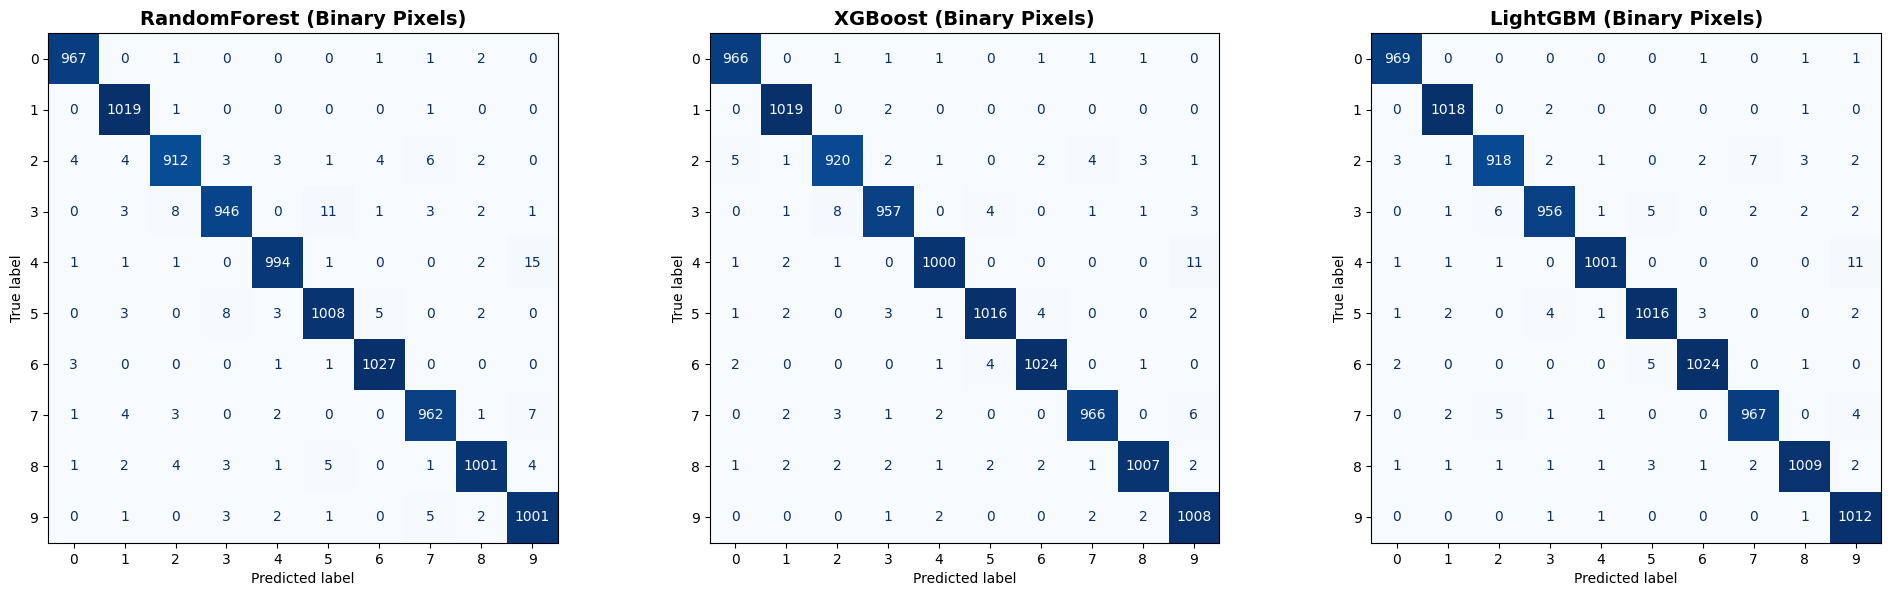

In [ ]:
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

print("--- [Step 1] 이진화 데이터 Flatten (2D -> 1D) ---")

# (N, 28, 28) -> (N, 784)
if 'X_train_bin' in locals():
    X_train_flat_bin = X_train_bin.reshape(X_train_bin.shape[0], -1)
    X_val_flat_bin   = X_val_bin.reshape(X_val_bin.shape[0], -1)

    print(f"학습 데이터 Shape: {X_train_flat_bin.shape}")
    print(f"검증 데이터 Shape: {X_val_flat_bin.shape}")

    print("\n--- [Step 2] 모델 학습 시작 (Input: Binary Raw Pixels) ---")

    training_jobs_raw = [
        # 1. RandomForest (CPU)
        ("RandomForest (Binary Pixels)",
         RandomForestClassifier(n_estimators=100, max_depth=16, random_state=42, n_jobs=-1),
         X_train_flat_bin, y_train_digit),

        # 2. XGBoost (GPU)
        ("XGBoost (Binary Pixels)",
         xgb.XGBClassifier(
             n_estimators=100, tree_method='hist', n_jobs = -1,
             objective='multi:softmax', num_class=10, random_state=42
         ),
         X_train_flat_bin, y_train_digit),

        # 3. LightGBM (CPU)
        ("LightGBM (Binary Pixels)",
         lgb.LGBMClassifier(
             n_estimators=100, n_jobs=-1, objective='multiclass',
             num_class=10, random_state=42, verbose=-1
         ),
         X_train_flat_bin, y_train_digit),
    ]

    trained_models_raw = {}

    for name, model, X_tr, y_tr in tqdm(training_jobs_raw, desc="Training Progress"):
        print(f"   -> {name} 학습 중...")
        model.fit(X_tr, y_tr)
        trained_models_raw[name] = model

    print("\n✅ 모델 학습 완료!")

    print("\n--- [Step 3] 최종 성능 평가 (Validation Set) ---")

    def evaluate_model_raw(model_name, model_obj, X_val, y_val):
        print(f"\n===== {model_name} =====")

        # 예측 (표준 sklearn 방식)
        try:
            y_pred = model_obj.predict(X_val)
            y_proba = model_obj.predict_proba(X_val)
        except Exception as e:
            print(f"예측 중 에러: {e}")
            return None

        # 결과 출력
        if y_pred is not None:
            # 정수형 변환
            y_val_int = y_val.astype(int)
            y_pred_int = y_pred.astype(int)

            print(classification_report(y_val_int, y_pred_int, digits=4))
            acc = accuracy_score(y_val_int, y_pred_int)
            print(f"   -> Accuracy: {acc:.4f}")

        if y_proba is not None:
            try:
                auc = roc_auc_score(y_val_int, y_proba, multi_class='ovr', average='weighted')
                print(f"   -> Weighted AUC: {auc:.4f}")
            except Exception as e:
                print(f"   -> AUC Error: {e}")

        return y_pred_int # Confusion Matrix를 위해 반환

    # --- Confusion Matrix 시각화 ---
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    axes = axes.flatten()

    for i, (name, model) in enumerate(trained_models_raw.items()):
        # 평가 및 예측값 획득
        y_pred = evaluate_model_raw(name, model, X_val_flat_bin, y_val_digit)

        if y_pred is not None:
            # 시각화
            y_val_int = y_val_digit.astype(int)
            cm = confusion_matrix(y_val_int, y_pred)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)
            disp.plot(ax=axes[i], cmap='Blues', values_format='d', colorbar=False)
            axes[i].set_title(f"{name}", fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

else:
    print("❌ 'X_train_bin' 데이터가 없습니다. 이진화(Binarization) 셀을 먼저 실행해주세요.")

## 배경제거+그레이스케일+이진화+HOG

In [ ]:
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from skimage.feature import hog
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# =========================================================
# 1. HOG 피처 추출 (Input: X_train_bin, X_val_bin)
# =========================================================
print("--- [Step 1] HOG 피처 추출 시작 (Input: Binary Image) ---")

def extract_hog_from_binary(images):
    hog_list = []
    # 파라미터: 4x4 cell (이진화된 이미지의 거친 엣지를 세밀하게 포착)
    ppc = 4
    cpb = 2

    # skimage hog는 CPU 연산이므로 tqdm으로 진행 상황 표시
    for img in tqdm(images, desc="HOG Extraction"):
        # visualize=False -> 벡터만 추출
        feat = hog(img, pixels_per_cell=(ppc, ppc),
                   cells_per_block=(cpb, cpb), visualize=False)
        hog_list.append(feat)
    return np.array(hog_list, dtype=np.float32)

# 데이터 존재 여부 확인 후 실행
if 'X_train_bin' in locals() and 'X_val_bin' in locals():
    print("1. 학습 데이터(X_train_bin) HOG 변환 중...")
    X_train_hog = extract_hog_from_binary(X_train_bin)

    print("2. 검증 데이터(X_val_bin) HOG 변환 중...")
    X_val_hog = extract_hog_from_binary(X_val_bin)

    print(f"   -> Final HOG Feature Shape: {X_train_hog.shape}")


    # =========================================================
    # 2. 모델 학습 (3종: RF, XGB, LGBM)
    # =========================================================
    print("\n--- [Step 2] 모델 학습 시작 (HOG Features) ---")

    training_jobs_hog = [
        # 1. RandomForest (CPU)
        ("RandomForest (HOG+Bin)",
         RandomForestClassifier(n_estimators=100, max_depth=16, random_state=42, n_jobs=-1),
         X_train_hog, y_train_digit),

        # 2. XGBoost (GPU)
        ("XGBoost (HOG+Bin)",
         xgb.XGBClassifier(n_estimators=100, tree_method='hist', n_jobs = -1,
                           objective='multi:softmax', num_class=10, random_state=42),
         X_train_hog, y_train_digit),

        # 3. LightGBM (CPU)
        # Colab 기본 환경 호환성을 위해 CPU 모드 권장
        ("LightGBM (HOG+Bin)",
         lgb.LGBMClassifier(n_estimators=100, n_jobs=-1, objective='multiclass',
                            num_class=10, random_state=42, verbose=-1),
         X_train_hog, y_train_digit),
    ]

    trained_models_hog = {}

    for name, model, X_tr, y_tr in tqdm(training_jobs_hog, desc="Training Models"):
        print(f"   -> {name} 학습 중...")
        model.fit(X_tr, y_tr)
        trained_models_hog[name] = model

    print("✅ 모든 모델 학습 완료!")


    # =========================================================
    # 3. 최종 성능 평가
    # =========================================================
    print("\n--- [Step 3] 최종 성능 평가 (Validation Set) ---")

    def evaluate_model(model_name, model_obj, X_val, y_val):
        print(f"\n===== {model_name} =====")

        # 모든 모델이 Numpy 배열 입력을 받습니다.
        try:
            y_pred = model_obj.predict(X_val)
            y_proba = model_obj.predict_proba(X_val)
        except Exception as e:
            print(f"예측 중 에러 발생: {e}")
            return

        # 결과 출력
        if y_pred is not None:
            # 정수형 변환
            y_val_int = y_val.astype(int)
            y_pred_int = y_pred.astype(int)

            print(classification_report(y_val_int, y_pred_int, digits=4))
            print(f"   -> Accuracy: {accuracy_score(y_val_int, y_pred_int):.4f}")

        if y_proba is not None:
            try:
                auc = roc_auc_score(y_val_int, y_proba, multi_class='ovr', average='weighted')
                print(f"   -> Weighted AUC: {auc:.4f}")
            except Exception as e:
                print(f"   -> AUC Error: {e}")

    # 평가 실행 (X_val_hog 사용)
    for name, model in trained_models_hog.items():
        evaluate_model(name, model, X_val_hog, y_val_digit)

else:
    print("❌ 'X_train_bin' 데이터가 없습니다. 이진화(Step 3) 셀을 먼저 실행해주세요.")

--- [Step 1] HOG 피처 추출 시작 (Input: Binary Image) ---
1. 학습 데이터(X_train_bin) HOG 변환 중...


HOG Extraction:   0%|          | 0/60000 [00:00<?, ?it/s]

2. 검증 데이터(X_val_bin) HOG 변환 중...


HOG Extraction:   0%|          | 0/10000 [00:00<?, ?it/s]

   -> Final HOG Feature Shape: (60000, 1296)

--- [Step 2] 모델 학습 시작 (HOG Features) ---


Training Models:   0%|          | 0/3 [00:00<?, ?it/s]

   -> RandomForest (HOG+Bin) 학습 중...
   -> XGBoost (HOG+Bin) 학습 중...
   -> LightGBM (HOG+Bin) 학습 중...
✅ 모든 모델 학습 완료!

--- [Step 3] 최종 성능 평가 (Validation Set) ---

===== RandomForest (HOG+Bin) =====
              precision    recall  f1-score   support

         0.0     0.9939    0.9990    0.9964       972
         1.0     0.9961    0.9931    0.9946      1021
         2.0     0.9852    0.9894    0.9872       939
         3.0     0.9816    0.9826    0.9821       975
         4.0     0.9911    0.9823    0.9866      1015
         5.0     0.9892    0.9835    0.9864      1029
         6.0     0.9923    0.9932    0.9927      1032
         7.0     0.9878    0.9898    0.9888       980
         8.0     0.9921    0.9853    0.9887      1022
         9.0     0.9815    0.9931    0.9873      1015

    accuracy                         0.9891     10000
   macro avg     0.9891    0.9891    0.9891     10000
weighted avg     0.9891    0.9891    0.9891     10000

   -> Accuracy: 0.9891
   -> Weighted AUC: 0

## Robustness 평가

In [ ]:
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from skimage.feature import hog
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# =========================================================
# 1. HOG 피처 추출 (Input: X_train_bin, X_val_bin, 증강 데이터들)
# =========================================================
print("--- [Step 1] HOG 피처 추출 시작 (Input: Binary Image) ---")

def extract_hog_from_binary(images):
    hog_list = []
    # 파라미터: 4x4 cell
    ppc = 4
    cpb = 2

    for img in tqdm(images, desc="HOG Extraction"):
        feat = hog(img, pixels_per_cell=(ppc, ppc),
                   cells_per_block=(cpb, cpb), visualize=False)
        hog_list.append(feat)
    return np.array(hog_list, dtype=np.float32)

# 데이터 존재 여부 확인 후 변환 수행
if 'X_train_bin' in locals() and 'X_val_bin' in locals():
    print("1. 학습 데이터(X_train_bin) HOG 변환 중...")
    X_train_hog = extract_hog_from_binary(X_train_bin)

    print("2. 검증 데이터(X_val_bin) HOG 변환 중...")
    X_val_hog = extract_hog_from_binary(X_val_bin)

    # 증강 데이터셋 변환 (존재하는 경우만)
    if 'X_val_all_bin' in locals():
        print("3. 증강 all 검증 데이터(X_val_all_bin) HOG 변환 중...")
        X_val_all_hog = extract_hog_from_binary(X_val_all_bin)

    if 'X_val_rotate_bin' in locals():
        print("4. 증강 rotate 검증 데이터(X_val_rotate_bin) HOG 변환 중...")
        X_val_rotate_hog = extract_hog_from_binary(X_val_rotate_bin)

    if 'X_val_scale_bin' in locals():
        print("5. 증강 scale 검증 데이터(X_val_scale_bin) HOG 변환 중...")
        X_val_scale_hog = extract_hog_from_binary(X_val_scale_bin)

    if 'X_val_shear_bin' in locals():
        print("6. 증강 shear 검증 데이터(X_val_shear_bin) HOG 변환 중...")
        X_val_shear_hog = extract_hog_from_binary(X_val_shear_bin)

    if 'X_val_shift_bin' in locals():
        print("7. 증강 shift 검증 데이터(X_val_shift_bin) HOG 변환 중...")
        X_val_shift_hog = extract_hog_from_binary(X_val_shift_bin)

    print(f"   -> Final HOG Feature Shape: {X_train_hog.shape}")


    # =========================================================
    # 2. 모델 학습 (3종: RF, XGB, LGBM)
    # =========================================================
    print("\n--- [Step 2] 모델 학습 시작 (HOG Features) ---")

    training_jobs_hog = [
        # 1. RandomForest (CPU)
        ("RandomForest (HOG+Bin)",
         RandomForestClassifier(n_estimators=100, max_depth=16, random_state=42, n_jobs=-1),
         X_train_hog, y_train_digit),

        # 2. XGBoost (GPU)
        ("XGBoost (HOG+Bin)",
         xgb.XGBClassifier(n_estimators=100, tree_method='hist', n_jobs = -1,
                           objective='multi:softmax', num_class=10, random_state=42),
         X_train_hog, y_train_digit),

        # 3. LightGBM (CPU)
        ("LightGBM (HOG+Bin)",
         lgb.LGBMClassifier(n_estimators=100, n_jobs=-1, objective='multiclass',
                            num_class=10, random_state=42, verbose=-1),
         X_train_hog, y_train_digit),
    ]

    trained_models_hog = {}

    for name, model, X_tr, y_tr in tqdm(training_jobs_hog, desc="Training Models"):
        print(f"   -> {name} 학습 중...")
        model.fit(X_tr, y_tr)
        trained_models_hog[name] = model

    print("✅ 모든 모델 학습 완료!")


    # =========================================================
    # 3. 최종 성능 평가
    # =========================================================
    print("\n--- [Step 3] 최종 성능 평가 (Validation Set) ---")

    def evaluate_model(model_name, model_obj, X_val, y_val):
        print(f"\n===== {model_name} =====")

        try:
            y_pred = model_obj.predict(X_val)
            y_proba = model_obj.predict_proba(X_val)
        except Exception as e:
            print(f"예측 중 에러: {e}")
            return

        # 결과 출력
        if y_pred is not None:
            # 정수형 변환
            y_val_int = y_val.astype(int)
            y_pred_int = y_pred.astype(int)

            print(classification_report(y_val_int, y_pred_int, digits=4))
            print(f"   -> Accuracy: {accuracy_score(y_val_int, y_pred_int):.4f}")

        if y_proba is not None:
            try:
                auc = roc_auc_score(y_val_int, y_proba, multi_class='ovr', average='weighted')
                print(f"   -> Weighted AUC: {auc:.4f}")
            except Exception as e:
                print(f"   -> AUC Error: {e}")

    # 평가 실행
    print("\n1. 기본 검증 데이터로 평가")
    for name, model in trained_models_hog.items():
        evaluate_model(name, model, X_val_hog, y_val_digit)

    if 'X_val_all_hog' in locals():
        print("\n2. 증강 ALL 검증 데이터로 평가")
        for name, model in trained_models_hog.items():
            evaluate_model(name, model, X_val_all_hog, y_val_all_digit)

    if 'X_val_rotate_hog' in locals():
        print("\n3. 증강 ROTATE 검증 데이터로 평가")
        for name, model in trained_models_hog.items():
            evaluate_model(name, model, X_val_rotate_hog, y_val_rotate_digit)

    if 'X_val_scale_hog' in locals():
        print("\n4. 증강 SCALE 검증 데이터로 평가")
        for name, model in trained_models_hog.items():
            evaluate_model(name, model, X_val_scale_hog, y_val_scale_digit)

    if 'X_val_shear_hog' in locals():
        print("\n5. 증강 SHEAR 검증 데이터로 평가")
        for name, model in trained_models_hog.items():
            evaluate_model(name, model, X_val_shear_hog, y_val_shear_digit)

    if 'X_val_shift_hog' in locals():
        print("\n6. 증강 SHIFT 검증 데이터로 평가")
        for name, model in trained_models_hog.items():
            evaluate_model(name, model, X_val_shift_hog, y_val_shift_digit)

else:
    print("❌ 'X_train_bin' 데이터가 없습니다. 이진화(Binarization) 셀을 먼저 실행해주세요.")

--- [Step 1] HOG 피처 추출 시작 (Input: Binary Image) ---
1. 학습 데이터(X_train_bin) HOG 변환 중...


HOG Extraction:   0%|          | 0/60000 [00:00<?, ?it/s]

2. 검증 데이터(X_val_bin) HOG 변환 중...


HOG Extraction:   0%|          | 0/10000 [00:00<?, ?it/s]

3. 증강 all 검증 데이터(X_val_all_bin) HOG 변환 중...


HOG Extraction:   0%|          | 0/10000 [00:00<?, ?it/s]

4. 증강 rotate 검증 데이터(X_val_rotate_bin) HOG 변환 중...


HOG Extraction:   0%|          | 0/10000 [00:00<?, ?it/s]

5. 증강 scale 검증 데이터(X_val_scale_bin) HOG 변환 중...


HOG Extraction:   0%|          | 0/10000 [00:00<?, ?it/s]

6. 장긍 shear 검증 데이터(X_val_shear_bin) HOG 변환 중...


HOG Extraction:   0%|          | 0/10000 [00:00<?, ?it/s]

7. 증강 shift 검증 데이터(X_val_shift_bin) HOG 변환 중...


HOG Extraction:   0%|          | 0/10000 [00:00<?, ?it/s]

   -> Final HOG Feature Shape: (60000, 1296)

--- [Step 2] 모델 학습 시작 (HOG Features) ---


Training Models:   0%|          | 0/3 [00:00<?, ?it/s]

   -> RandomForest (HOG+Bin) 학습 중...
   -> XGBoost (HOG+Bin) 학습 중...
   -> LightGBM (HOG+Bin) 학습 중...
✅ 모든 모델 학습 완료!

--- [Step 3] 최종 성능 평가 (Validation Set) ---

1. 기본 검증 데이터로 평가


===== RandomForest (HOG+Bin) =====
              precision    recall  f1-score   support

         0.0     0.9939    0.9990    0.9964       972
         1.0     0.9961    0.9931    0.9946      1021
         2.0     0.9852    0.9894    0.9872       939
         3.0     0.9816    0.9826    0.9821       975
         4.0     0.9911    0.9823    0.9866      1015
         5.0     0.9892    0.9835    0.9864      1029
         6.0     0.9923    0.9932    0.9927      1032
         7.0     0.9878    0.9898    0.9888       980
         8.0     0.9921    0.9853    0.9887      1022
         9.0     0.9815    0.9931    0.9873      1015

    accuracy                         0.9891     10000
   macro avg     0.9891    0.9891    0.9891     10000
weighted avg     0.9891    0.9891    0.9891     10000

   -> Accuracy: 0.9891
  

## confusion matrix 배경제거, 그레이스케일, 이진화, hog


--- [Step 4] Confusion Matrix 시각화 ---


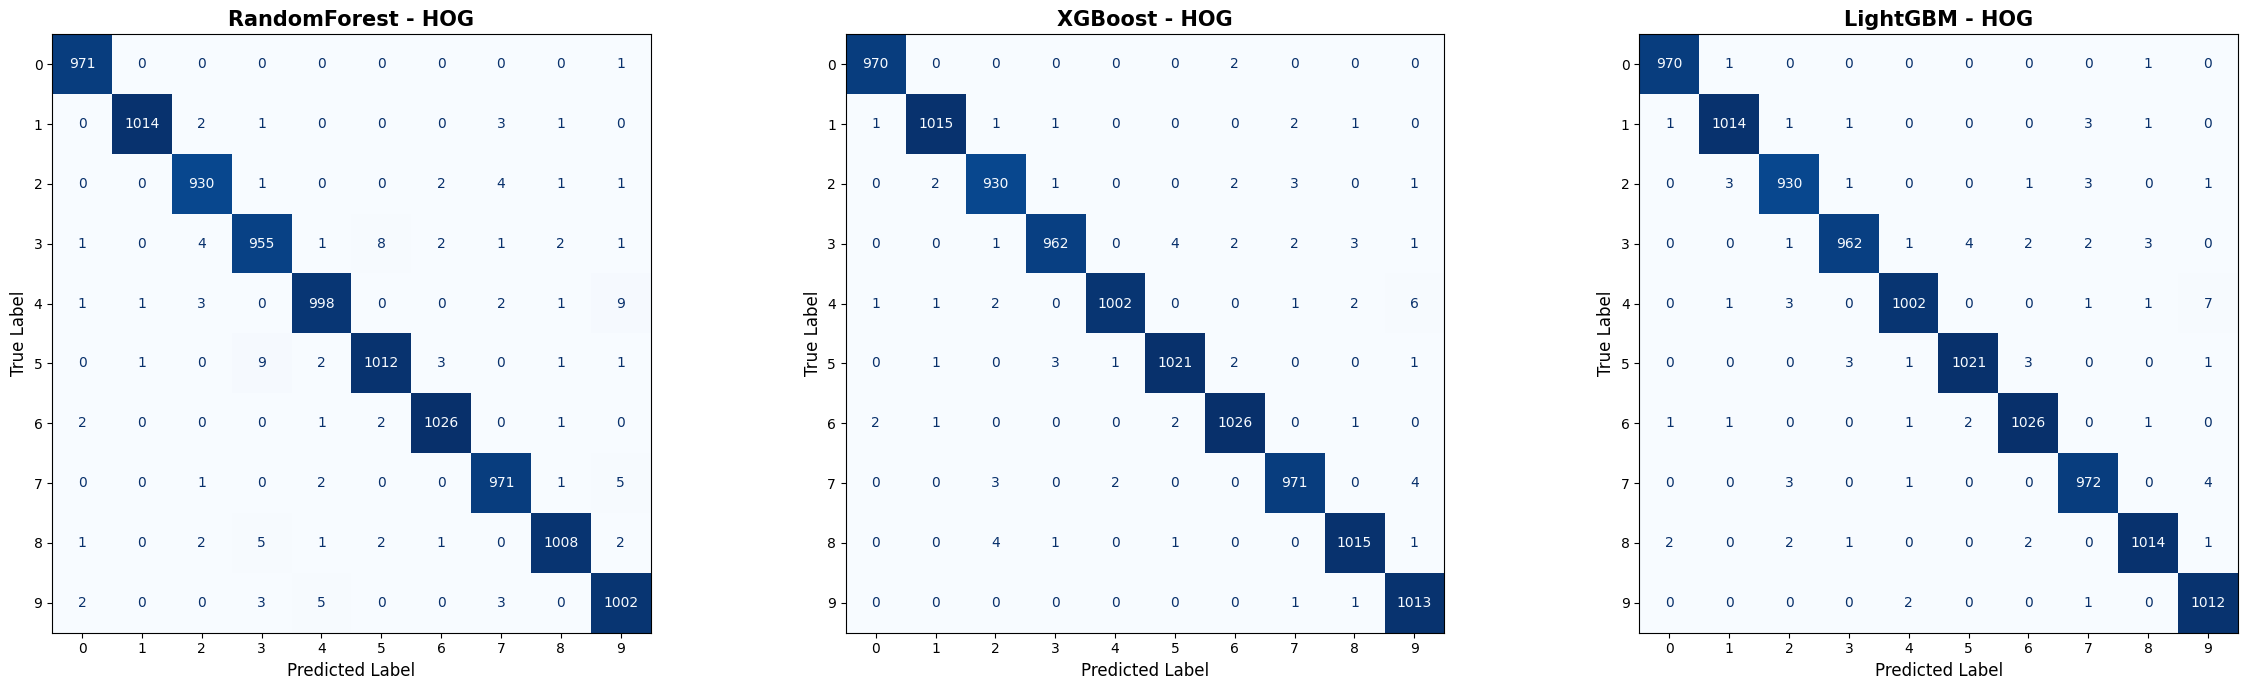

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# =========================================================
# 4. Confusion Matrix 시각화
# =========================================================
print("\n--- [Step 4] Confusion Matrix 시각화 ---")

# 데이터 및 모델 존재 여부 확인
if 'trained_models_hog' not in locals() or not trained_models_hog:
    print("⚠️ 학습된 모델(trained_models_hog)이 없습니다. HOG 모델 학습 셀을 먼저 실행해주세요.")
elif 'X_val_hog' not in locals():
    print("⚠️ 검증 데이터(X_val_hog)가 없습니다. HOG 피처 추출 셀을 먼저 실행해주세요.")
else:
    # 그래프 설정 (1행 3열)
    fig, axes = plt.subplots(1, 3, figsize=(24, 7))
    axes = axes.flatten()

    # 학습된 모델들을 순회하며 행렬 그리기
    for i, (name, model) in enumerate(trained_models_hog.items()):

        # 1. 예측값 생성
        # cuRF(GPU) 분기 제거 -> 모든 모델이 Numpy 배열(X_val_hog)을 직접 입력받습니다.
        try:
            y_pred = model.predict(X_val_hog)
        except Exception as e:
            print(f"예측 중 에러 ({name}): {e}")
            continue

        # 2. Confusion Matrix 계산
        # 정수형 변환 (깔끔한 출력을 위해)
        y_true_int = y_val_digit.astype(int)
        y_pred_int = y_pred.astype(int)

        cm = confusion_matrix(y_true_int, y_pred_int)

        # 3. 시각화 (Plot)
        # 인덱스 범위 체크 (모델이 3개보다 많을 경우 대비)
        if i < len(axes):
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)
            disp.plot(ax=axes[i], cmap='Blues', values_format='d', colorbar=False)

            # 제목 및 스타일 설정
            axes[i].set_title(f"{name}", fontsize=15, fontweight='bold')
            axes[i].set_xlabel('Predicted Label', fontsize=12)
            axes[i].set_ylabel('True Label', fontsize=12)

    # 레이아웃 정리 및 출력
    plt.tight_layout()
    plt.show()

## 클러스터 확인 - umap

--- [Visualization] UMAP for All 3 Models (1x3 Layout) ---
UMAP 계산 중 (Common Coordinates)...
[2025-12-01 17:02:58.640] [CUML] [info] build_algo set to brute_force_knn because random_state is given
   -> UMAP 완료 (1.14초)
[RandomForest - HOG] 예측 및 플로팅 중...
[XGBoost - HOG] 예측 및 플로팅 중...
[LightGBM - HOG] 예측 및 플로팅 중...


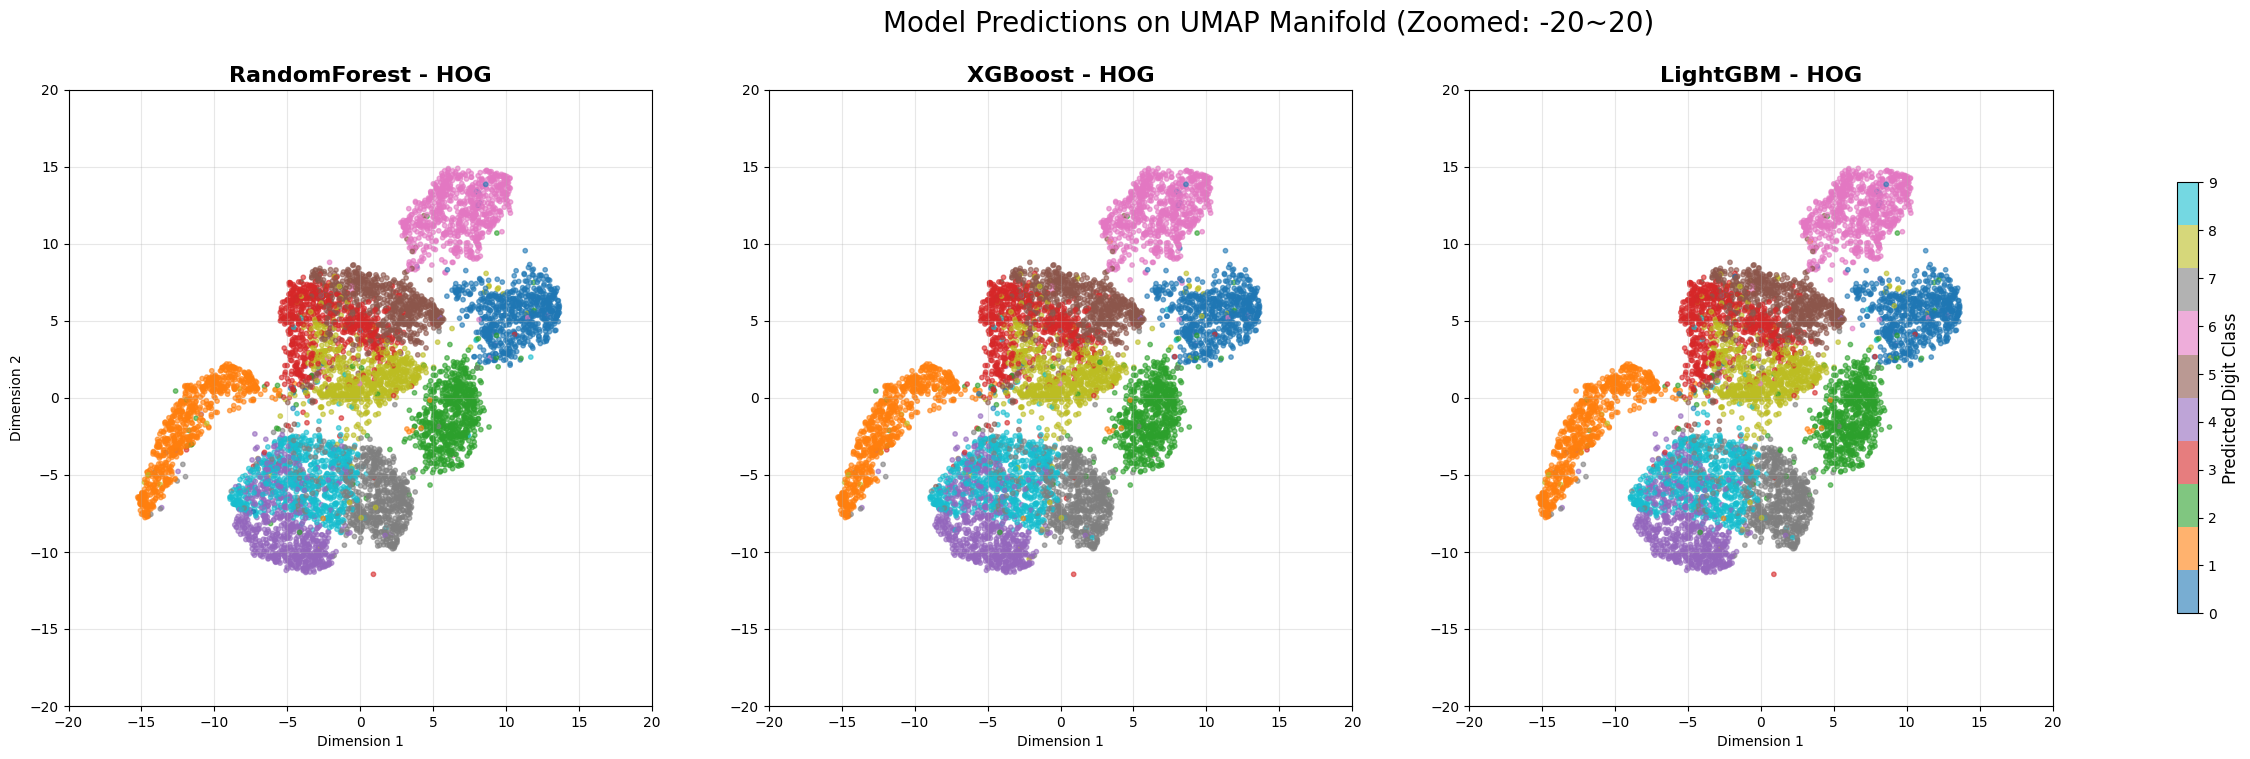

In [ ]:
# UMAP 라이브러리 임포트 (설치 안 되어 있을 경우 대비)
try:
    from umap import UMAP
except ImportError:
    !pip install umap-learn
    from umap import UMAP

import matplotlib.pyplot as plt
import numpy as np
import time

# =========================================================
# 3종 모델 UMAP 시각화 (1x3 배치, 좌표 고정)
# =========================================================
print("--- [Visualization] UMAP for All 3 Models (1x3 Layout) ---")

# 데이터 존재 여부 확인
if 'X_val_hog' not in locals():
    print("❌ 오류: 'X_val_hog' 데이터가 없습니다. HOG 피처 추출 셀을 먼저 실행해주세요.")
elif 'trained_models_hog' not in locals():
    print("❌ 오류: 'trained_models_hog' 모델이 없습니다. HOG 모델 학습 셀을 먼저 실행해주세요.")
else:
    # 1. UMAP 계산 (한 번만 수행하여 좌표 고정)
    # Colab CPU 환경이므로 cuml.UMAP 대신 umap.UMAP 사용
    print("UMAP 계산 중 (Common Coordinates - CPU)...")
    start = time.time()

    # 파라미터: n_neighbors=30, min_dist=0.8, spread=2.0
    # CPU 버전 UMAP은 random_state 처리가 약간 다를 수 있으나 최대한 고정합니다.
    umap_reducer = UMAP(n_components=2, n_neighbors=30, min_dist=0.8, metric='euclidean', spread=2.0, random_state=42)
    X_umap = umap_reducer.fit_transform(X_val_hog)

    print(f"   -> UMAP 완료 ({time.time()-start:.2f}초)")

    # 2. 시각화 설정
    fig, axes = plt.subplots(1, 3, figsize=(32, 8))
    axes = axes.flatten()

    # 모델 리스트 정의 (순서대로 출력)
    target_keywords = ["RandomForest", "XGBoost", "LightGBM"]
    found_models = []

    for keyword in target_keywords:
        for name, model in trained_models_hog.items():
            if keyword in name:
                found_models.append((name, model))
                break

    # 3. 모델별 예측 및 그리기
    for i, (name, model) in enumerate(found_models):
        print(f"[{name}] 예측 및 플로팅 중...")

        # 예측 수행
        # cuRF(GPU) 분기 제거 -> 모든 모델이 Numpy 배열(X_val_hog)을 직접 입력받습니다.
        try:
            y_pred = model.predict(X_val_hog)
        except Exception as e:
            print(f"예측 중 에러 ({name}): {e}")
            continue

        # 정수형 변환 (깔끔한 시각화를 위해)
        y_pred = y_pred.astype(int)

        # 산점도 그리기
        # UMAP 좌표는 공유하고, 색깔(c)만 모델의 예측값으로 바꿉니다.
        ax = axes[i]
        scatter = ax.scatter(X_umap[:, 0], X_umap[:, 1], c=y_pred,
                             cmap='tab10', s=10, alpha=0.6)

        # [핵심] 보여줄 범위 제한 (Zoom In)
        # 데이터 분포에 따라 범위가 다를 수 있으니, 필요한 경우 주석 처리하거나 조정하세요.
        # ax.set_xlim(-20, 20)
        # ax.set_ylim(-20, 20)

        # 타이틀 및 레이블
        ax.set_title(f"{name}", fontsize=16, fontweight='bold')
        ax.set_xlabel("Dimension 1")
        if i == 0: ax.set_ylabel("Dimension 2") # 첫 번째 그래프에만 Y축 레이블 표시
        ax.grid(True, alpha=0.3)

    # 공통 컬러바 (오른쪽에 하나 배치)
    cbar = fig.colorbar(scatter, ax=axes, location='right', shrink=0.7)
    cbar.set_label('Predicted Digit Class', fontsize=12)
    # 클래스가 10개(0~9)인 경우 틱 설정
    cbar.set_ticks(range(10))

    plt.suptitle(f"Model Predictions on UMAP Manifold", fontsize=20)
    plt.show()

## 클러스터 확인 - t-sne

--- [Visualization] t-SNE for All 3 Models (1x3 Layout) ---
t-SNE 계산 중 (Common Coordinates)...
   -> t-SNE 완료 (1.82초)
[RandomForest - HOG] 예측 및 플로팅 중...
[XGBoost - HOG] 예측 및 플로팅 중...
[LightGBM - HOG] 예측 및 플로팅 중...


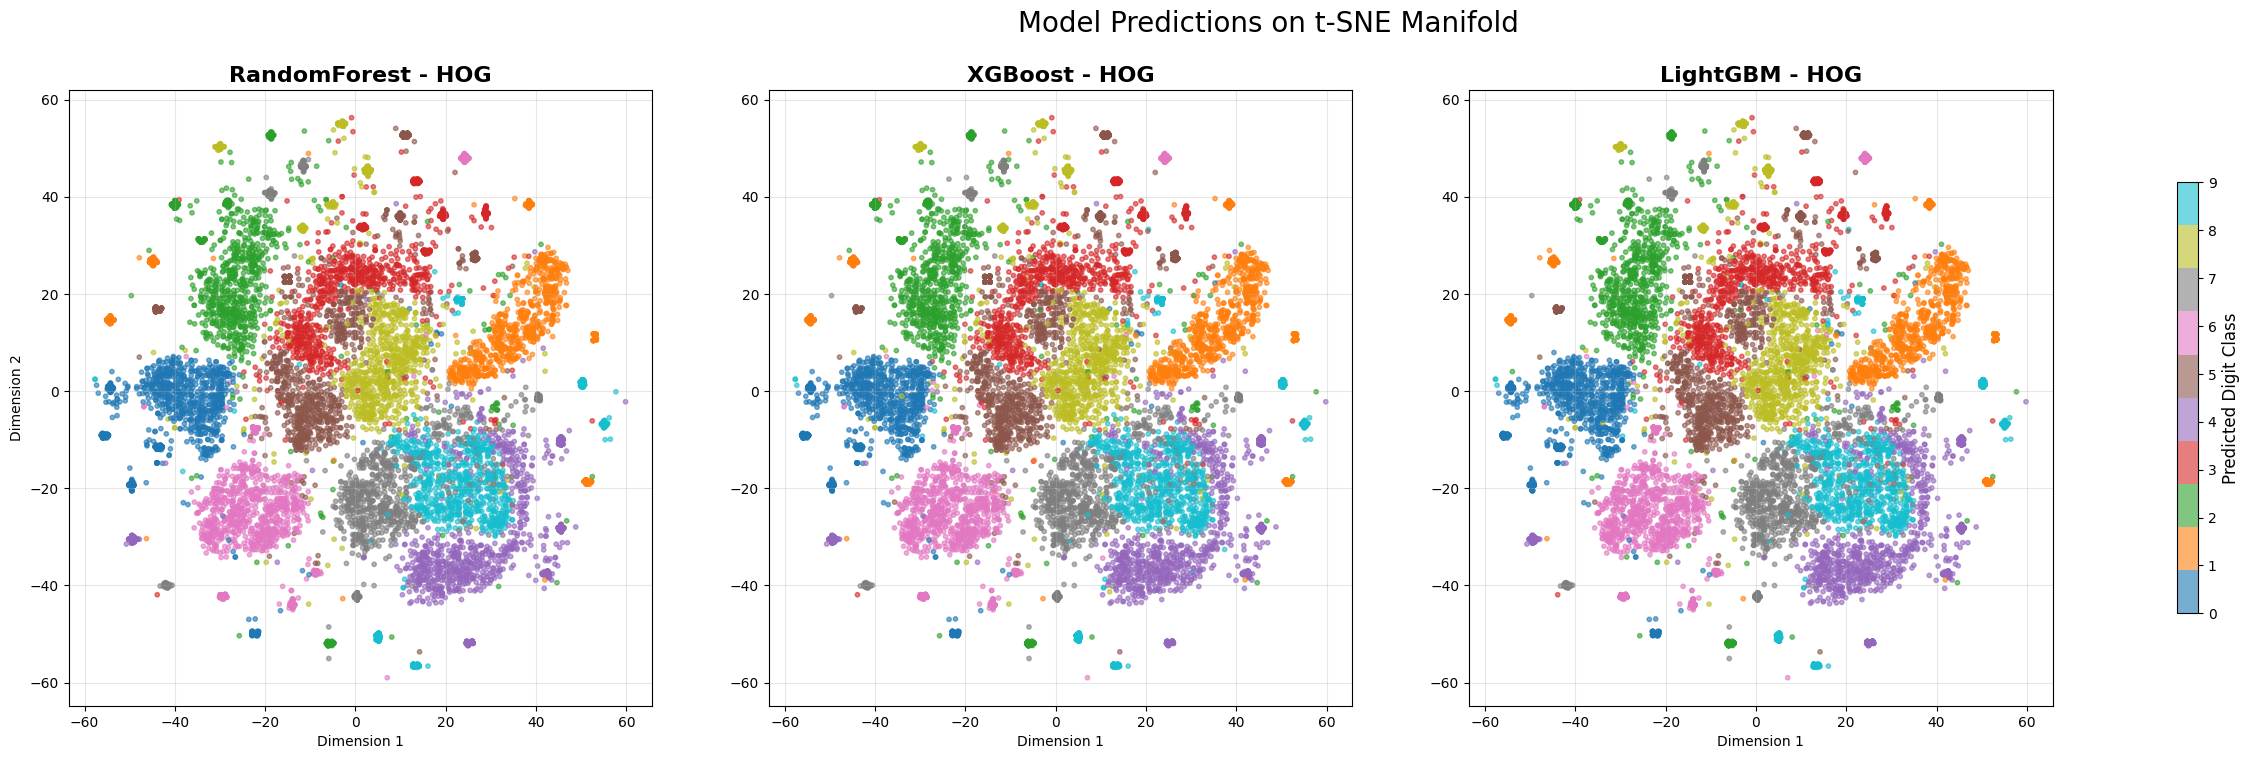

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE  # cuml -> sklearn 변경
import time

# =========================================================
# 3종 모델 t-SNE 시각화 (1x3 배치, 좌표 고정)
# =========================================================
print("--- [Visualization] t-SNE for All 3 Models (1x3 Layout) ---")

# 데이터 및 모델 확인
if 'X_val_hog' not in locals():
    print("❌ 오류: 'X_val_hog' 데이터가 없습니다.")
elif 'trained_models_hog' not in locals():
    print("❌ 오류: 'trained_models_hog' 모델이 없습니다.")
else:
    # 1. t-SNE 계산 (한 번만 수행하여 좌표 고정)
    # CPU 연산이므로 데이터 양에 따라 시간이 소요됩니다.
    print("t-SNE 계산 중 (Common Coordinates - CPU)...")
    print("   (잠시만 기다려주세요...)")
    start = time.time()

    # n_jobs=-1 옵션으로 가능한 모든 CPU 코어 사용
    tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42, n_jobs=-1)
    X_tsne = tsne.fit_transform(X_val_hog)

    print(f"   -> t-SNE 완료 ({time.time()-start:.2f}초)")

    # 2. 시각화 설정
    fig, axes = plt.subplots(1, 3, figsize=(32, 8))
    axes = axes.flatten()

    # 모델 리스트 정의 (순서대로 출력)
    target_keywords = ["RandomForest", "XGBoost", "LightGBM"]
    found_models = []

    for keyword in target_keywords:
        for name, model in trained_models_hog.items():
            if keyword in name:
                found_models.append((name, model))
                break

    # 3. 모델별 예측 및 그리기
    for i, (name, model) in enumerate(found_models):
        print(f"[{name}] 예측 및 플로팅 중...")

        # 예측 수행
        # cuRF(GPU) 분기를 제거하고 Numpy 배열을 바로 입력합니다.
        try:
            y_pred = model.predict(X_val_hog)
        except Exception as e:
            print(f"예측 에러 ({name}): {e}")
            continue

        # 정수형 변환 (시각화 색상 매핑용)
        y_pred = y_pred.astype(int)

        # 산점도 그리기 (X_tsne 좌표 사용)
        ax = axes[i]
        scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_pred,
                             cmap='tab10', s=10, alpha=0.6)

        # [범위 설정] t-SNE는 결과마다 범위가 다르므로 자동 설정을 권장합니다.
        # 필요하다면 실행 후 결과를 보고 주석을 해제하여 범위를 고정하세요.
        # ax.set_xlim(-100, 100)
        # ax.set_ylim(-100, 100)

        # 타이틀 및 레이블
        ax.set_title(f"{name}", fontsize=16, fontweight='bold')
        ax.set_xlabel("Dimension 1")
        if i == 0: ax.set_ylabel("Dimension 2")
        ax.grid(True, alpha=0.3)

    # 공통 컬러바
    cbar = fig.colorbar(scatter, ax=axes, location='right', shrink=0.7)
    cbar.set_label('Predicted Digit Class', fontsize=12)
    cbar.set_ticks(range(10))

    plt.suptitle(f"Model Predictions on t-SNE Manifold", fontsize=20)
    plt.show()

## 배경제거 시각화

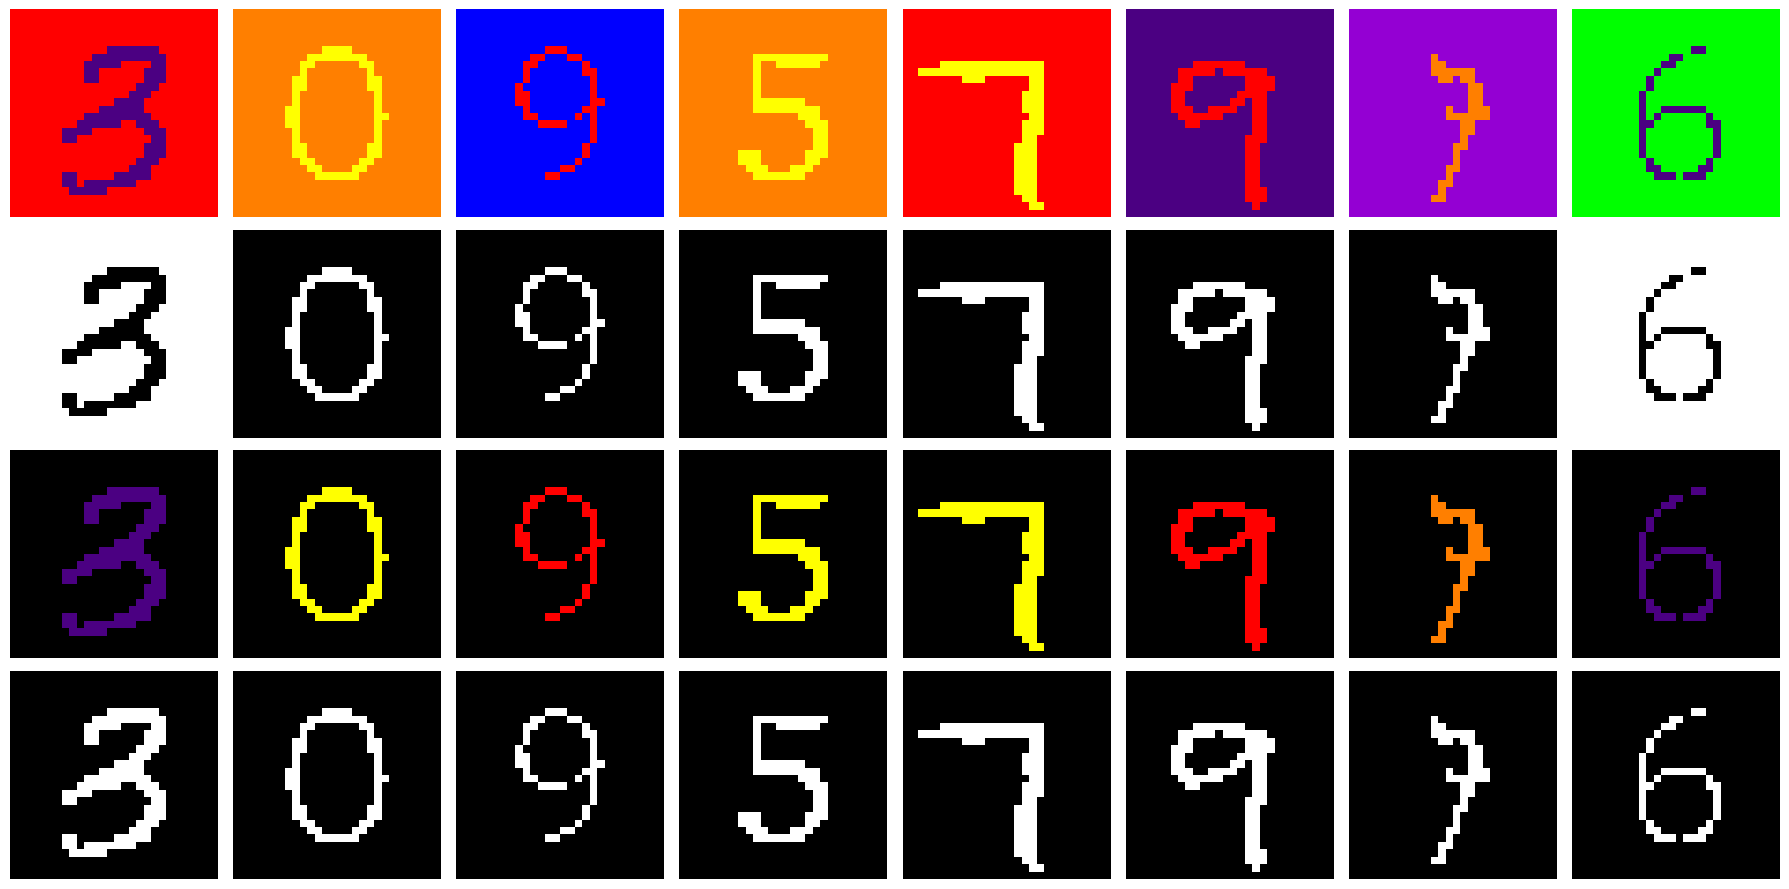

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# (최종) Original / Gray-only / NoBG RGB / NoBG+Gray 비교 시각화 (샘플 8개)
# ===============================

# 필요한 모든 데이터가 메모리에 있는지 확인
required_vars = ['X_train_color', 'X_train_gray', 'X_train_nobg', 'X_train_nobg_gray']
missing_vars = [var for var in required_vars if var not in locals()]

if not missing_vars:
    num_samples = 8
    # 랜덤 인덱스 선택
    idx_compare = np.random.choice(X_train_color.shape[0], num_samples, replace=False)

    plt.figure(figsize=(18, 10))

    for col, i in enumerate(idx_compare):

        # 1) 원본 RGB
        ax1 = plt.subplot(4, num_samples, col + 1)
        ax1.imshow(X_train_color[i])
        ax1.axis('off')
        if col == 0:
            ax1.set_ylabel("Original RGB", fontsize=12, fontweight='bold')
            ax1.set_title(f"Index {i}") # 인덱스 표시

        # 2) Grayscale만 적용 (단순 변환)
        ax2 = plt.subplot(4, num_samples, num_samples + col + 1)
        ax2.imshow(X_train_gray[i], cmap='gray')
        ax2.axis('off')
        if col == 0:
            ax2.set_ylabel("Gray Only", fontsize=12, fontweight='bold')

        # 3) 배경제거된 RGB
        ax3 = plt.subplot(4, num_samples, 2*num_samples + col + 1)
        ax3.imshow(X_train_nobg[i])
        ax3.axis('off')
        if col == 0:
            ax3.set_ylabel("NoBG RGB", fontsize=12, fontweight='bold')

        # 4) 배경제거 + Grayscale (최종 전처리 형태)
        ax4 = plt.subplot(4, num_samples, 3*num_samples + col + 1)
        ax4.imshow(X_train_nobg_gray[i], cmap='gray')
        ax4.axis('off')
        if col == 0:
            ax4.set_ylabel("NoBG + Gray", fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()

else:
    print(f"❌ 다음 데이터 변수가 없습니다: {missing_vars}")
    print("이전의 데이터 로딩 및 전처리(그레이스케일 변환, 배경 제거 등) 셀들을 모두 실행했는지 확인해주세요.")

## 배경제거+그레이스케일+HOG

In [ ]:
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from skimage.feature import hog
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report as sk_classification_report
from sklearn.metrics import roc_auc_score as sk_roc_auc_score

# =========================================================
# 7. HOG 피처 추출 (배경 제거된 Grayscale 이미지 사용)
# =========================================================
print("\n--- [Step 7] HOG 피처 추출 시작 ---")

# 데이터 존재 여부 확인
if 'X_train_nobg_gray' in locals() and 'X_val_nobg_gray' in locals():

    def extract_hog_features(images):
        """
        images: (N, H, W) 형태의 Grayscale 이미지
        """
        hog_list = []
        # MNIST에 최적화된 파라미터 (4x4 셀, 2x2 블록)
        ppc = 4
        cpb = 2

        # 진행률 표시와 함께 추출
        for img in tqdm(images, desc="Extracting HOG"):
            # visualize=False로 설정하여 피처 벡터만 빠르게 추출
            feat = hog(img, pixels_per_cell=(ppc, ppc),
                       cells_per_block=(cpb, cpb), visualize=False)
            hog_list.append(feat)

        return np.array(hog_list, dtype=np.float32)

    # 학습 데이터 HOG 변환
    print("학습 데이터 HOG 변환 중...")
    X_train_hog = extract_hog_features(X_train_nobg_gray)

    # 검증 데이터 HOG 변환
    print("검증 데이터 HOG 변환 중...")
    X_val_hog = extract_hog_features(X_val_nobg_gray)

    print(f"HOG Feature Shape: {X_train_hog.shape}")


    # =========================================================
    # 8. HOG 피처 기반 모델 학습
    # =========================================================
    print("\n--- [Step 8] HOG 기반 모델 3종 학습 시작 ---")

    # 학습 작업 목록 정의
    training_jobs_hog = [
        # 1. RandomForest (CPU)
        ("RandomForest - HOG",
         RandomForestClassifier(n_estimators=100, max_depth=16, random_state=42, n_jobs=-1),
         X_train_hog, y_train_digit),

        # 2. XGBoost (GPU)
        ("XGBoost - HOG",
         xgb.XGBClassifier(
             n_estimators=100, tree_method='hist', n_jobs = -1,
             objective='multi:softmax', num_class=10, random_state=42
         ),
         X_train_hog, y_train_digit),

        # 3. LightGBM (CPU)
        # Colab 기본 환경 호환성을 위해 CPU 모드 권장
        ("LightGBM - HOG",
         lgb.LGBMClassifier(
             n_estimators=100, n_jobs=-1, objective='multiclass',
             num_class=10, random_state=42, verbose=-1
         ),
         X_train_hog, y_train_digit),
    ]

    trained_models_hog = {}

    # 학습 루프 실행
    for name, model, X_tr, y_tr in tqdm(training_jobs_hog, desc="HOG Training Progress"):
        print(f"학습 중: {name}...")
        model.fit(X_tr, y_tr)
        trained_models_hog[name] = model

    print("\n--- 모든 HOG 모델 학습 완료 ---")


    # =========================================================
    # 9. HOG 모델 성능 평가
    # =========================================================
    print("\n--- [Step 9] HOG 모델 최종 성능 평가 ---")

    def evaluate_model_hog(model_name, model_obj, X_val, y_val):
        print(f"\n===== {model_name} =====")

        # 1. 예측 (표준 sklearn 방식으로 통일)
        try:
            y_pred = model_obj.predict(X_val)
            y_proba = model_obj.predict_proba(X_val)
        except Exception as e:
            print(f"예측 중 에러 발생: {e}")
            return

        # 2. 결과 출력
        if y_pred is not None:
            # 정수형 변환
            y_val_int = y_val.astype(int)
            y_pred_int = y_pred.astype(int)

            print(sk_classification_report(y_val_int, y_pred_int, digits=4))

        if y_proba is not None:
            try:
                auc = sk_roc_auc_score(y_val_int, y_proba, multi_class='ovr', average='weighted')
                print(f"** Weighted-Average AUC: {auc:.4f} **")
            except Exception as e:
                print(f"AUC 계산 중 오류: {e}")

    # 학습된 HOG 모델들을 순회하며 평가
    for name, model in trained_models_hog.items():
        # 평가 함수에 X_val_hog 데이터를 명시적으로 전달
        evaluate_model_hog(name, model, X_val_hog, y_val_digit)

else:
    print("❌ 'X_train_nobg_gray' 또는 'X_val_nobg_gray' 데이터가 없습니다. 이전 전처리 단계(배경제거+그레이스케일)를 먼저 실행해주세요.")


--- [Step 7] HOG 피처 추출 시작 ---
학습 데이터 HOG 변환 중...


Extracting HOG:   0%|          | 0/60000 [00:00<?, ?it/s]

검증 데이터 HOG 변환 중...


Extracting HOG:   0%|          | 0/10000 [00:00<?, ?it/s]

HOG Feature Shape: (60000, 1296)

--- [Step 8] HOG 기반 모델 3종 학습 시작 ---


HOG Training Progress:   0%|          | 0/3 [00:00<?, ?it/s]


--- 모든 HOG 모델 학습 완료 ---

--- [Step 9] HOG 모델 최종 성능 평가 ---

===== RandomForest - HOG =====
              precision    recall  f1-score   support

         0.0     0.9928    0.9990    0.9959       972
         1.0     0.9980    0.9931    0.9956      1021
         2.0     0.9873    0.9904    0.9888       939
         3.0     0.9805    0.9795    0.9800       975
         4.0     0.9881    0.9833    0.9857      1015
         5.0     0.9883    0.9835    0.9859      1029
         6.0     0.9923    0.9942    0.9932      1032
         7.0     0.9868    0.9908    0.9888       980
         8.0     0.9921    0.9863    0.9892      1022
         9.0     0.9804    0.9872    0.9838      1015

    accuracy                         0.9887     10000
   macro avg     0.9887    0.9887    0.9887     10000
weighted avg     0.9887    0.9887    0.9887     10000

** Weighted-Average AUC: 0.9999 **

===== XGBoost - HOG =====
              precision    recall  f1-score   support

         0.0     0.9959    0.9979

## 과적합 판단

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score

# ==========================================
# 과적합(Overfitting) 진단 함수
# ==========================================
def check_overfitting_hog(model_name, model_obj, X_train, y_train, X_val, y_val):
    print(f"\n===== [과적합 체크] {model_name} =====")

    # 1. 학습 데이터(Train)에 대한 예측
    try:
        # 모든 모델(RF, XGB, LGBM)이 Numpy 배열을 직접 입력받습니다.
        y_train_pred = model_obj.predict(X_train)
    except Exception as e:
        print(f"학습 데이터 예측 중 에러: {e}")
        return

    # 2. 검증 데이터(Validation)에 대한 예측
    try:
        y_val_pred = model_obj.predict(X_val)
    except Exception as e:
        print(f"검증 데이터 예측 중 에러: {e}")
        return

    # 3. 정확도 계산 및 비교
    # 정수형으로 변환하여 비교
    y_train_int = y_train.astype(int)
    y_val_int = y_val.astype(int)
    y_train_pred_int = y_train_pred.astype(int)
    y_val_pred_int = y_val_pred.astype(int)

    train_acc = accuracy_score(y_train_int, y_train_pred_int)
    val_acc = accuracy_score(y_val_int, y_val_pred_int)

    # Gap 계산 (Train - Val)
    gap = train_acc - val_acc

    # 4. 결과 출력
    print(f"   - 학습 정확도 (Train) : {train_acc:.4f} ({train_acc*100:.2f}%)")
    print(f"   - 검증 정확도 (Val)   : {val_acc:.4f} ({val_acc*100:.2f}%)")
    print(f"   - 차이 (Gap)          : {gap:.4f} ({gap*100:.2f}% 차이)")

    # 5. 진단 메시지
    if gap > 0.10:
        print("   🔥 [위험] 심각한 과적합(Overfitting)입니다! 모델이 학습 데이터를 암기하고 있습니다.")
    elif gap > 0.05:
        print("   🚨 [경고] 과적합 조짐이 있습니다. (차이 > 5%)")
    elif val_acc < 0.60:
        print("   ⚠️ [주의] 과소적합(Underfitting) 가능성이 있습니다. 학습이 더 필요합니다.")
    else:
        print("   ✅ [양호] 학습이 안정적으로 잘 되었습니다. (Good Fit)")

# ==========================================
# 실행 코드
# ==========================================
# 데이터 존재 여부 확인
if 'trained_models_hog' in locals() and 'X_train_hog' in locals() and 'X_val_hog' in locals():
    print("--- HOG 모델 과적합 진단 시작 ---")

    # trained_models_hog 딕셔너리에 있는 모든 모델 검사
    for name, model in trained_models_hog.items():
        check_overfitting_hog(name, model,
                              X_train_hog, y_train_digit,
                              X_val_hog, y_val_digit)
else:
    print("⚠️ 필요한 데이터(trained_models_hog 등)가 없습니다. HOG 모델 학습 단계를 먼저 실행해주세요.")

--- HOG 모델 과적합 진단 시작 ---

===== [과적합 체크] RandomForest (HOG+Bin) =====
   - 학습 정확도 (Train) : 0.9998 (99.98%)
   - 검증 정확도 (Val)   : 0.9891 (98.91%)
   - 차이 (Gap)          : 0.0107 (1.07% 차이)
   ✅ [양호] 학습이 안정적으로 잘 되었습니다. (Good Fit)

===== [과적합 체크] XGBoost (HOG+Bin) =====
   - 학습 정확도 (Train) : 1.0000 (100.00%)
   - 검증 정확도 (Val)   : 0.9929 (99.29%)
   - 차이 (Gap)          : 0.0071 (0.71% 차이)
   ✅ [양호] 학습이 안정적으로 잘 되었습니다. (Good Fit)

===== [과적합 체크] LightGBM (HOG+Bin) =====
   - 학습 정확도 (Train) : 1.0000 (100.00%)
   - 검증 정확도 (Val)   : 0.9931 (99.31%)
   - 차이 (Gap)          : 0.0069 (0.69% 차이)
   ✅ [양호] 학습이 안정적으로 잘 되었습니다. (Good Fit)


## 색상 처리 시간 단축 코드 수정 필요


In [ ]:
def extract_smart_color_features(images_color_flat, images_gray_flat, threshold=0.1):
    N = images_color_flat.shape[0]
    # shape 복구
    images_color = images_color_flat.reshape(N, 28, 28, 3)
    images_gray = images_gray_flat.reshape(N, 28, 28)

    fg_features = np.zeros((N, 3))
    bg_features = np.zeros((N, 3))

    # BG: 네 모서리 평균
    corners = images_color[:, [0, 0, -1, -1], [0, -1, 0, -1], :]
    bg_features = np.mean(corners, axis=1)

    # FG: 마스킹
    for i in range(N):
        mask = images_gray[i] > threshold
        if np.sum(mask) > 0:
            fg_features[i] = np.mean(images_color[i][mask], axis=0)
        else:
            # 여전히 숫자가 안 보이면 배경색으로 대체
            fg_features[i] = bg_features[i]

    return fg_features, bg_features

# --- [Step 2] 데이터 변환 (Correct Threshold) ---
print(">>> [수정됨] 색상 데이터 다시 추출 중 (Threshold=0.1)...")
# 학습 데이터
X_train_fg, X_train_bg = extract_smart_color_features(X_train_flat_color, X_train_flat_gray, threshold=0.1)
# 테스트 데이터
X_val_fg, X_val_bg = extract_smart_color_features(X_val_flat_color, X_val_flat_gray, threshold=0.1)
print(">>> 변환 완료 (FG)")

# --- [Step 3] 모델 학습 & 평가 (RF, XGB, LGBM Only) ---
training_jobs = [
    # 1. Foreground (전경색)
    ("RF - FG", cuRF(n_estimators=100, random_state=42), X_train_fg, y_train_fg, X_val_fg, y_val_fg),
    ("XGB - FG", xgb.XGBClassifier(n_estimators=100, n_jobs=-1, random_state=42), X_train_fg, y_train_fg, X_val_fg, y_val_fg),
    ("LGBM - FG", lgb.LGBMClassifier(n_estimators=100, n_jobs=-1, random_state=42, verbosity=-1), X_train_fg, y_train_fg, X_val_fg, y_val_fg),

    # 2. Background (배경색)
    ("RF - BG", cuRF(n_estimators=100, n_jobs=-1, random_state=42), X_train_bg, y_train_bg, X_val_bg, y_val_bg),
    ("XGB - BG", xgb.XGBClassifier(n_estimators=100, n_jobs=-1, random_state=42), X_train_bg, y_train_bg, X_val_bg, y_val_bg),
    ("LGBM - BG", lgb.LGBMClassifier(n_estimators=100, n_jobs=-1, random_state=42, verbosity=-1), X_train_bg, y_train_bg, X_val_bg, y_val_bg),
]

# 시각화 설정
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

print("\n>>> 모델 학습 시작")
results = {}

for i, (name, model, X_tr, y_tr, X_te, y_te) in enumerate(tqdm(training_jobs)):
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    acc = sk_accuracy_score(y_te, y_pred)
    results[name] = acc

    cm = confusion_matrix(y_te, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axes[i], cmap='Blues', values_format='d', colorbar=False)
    axes[i].set_title(f"{name}\nAcc: {acc:.2%}", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n=== 🏆 Final Score (Redemption Round) ===")
for name, acc in results.items():
    print(f"{name:<15} : {acc:.2%}")